<a id="topV"></a>

# Viewing COS Data

# Learning Goals

<font size="4 ">This Notebook is designed to walk the user (<em>you</em>) through:</font><br>
    
**0. [Introduction](#introV)**

\- 0.1. [A one-cell summary of this Notebook's key points](#onecellV) 

**1. [Reading in the data](#readInV) using `Python`**

\- 1.1. [Investigating the Data - *Basics*](#investV)
    
\- 1.2. [Reading in the `x1d`/`x1dsum` Main Data](#readmainV)
    
\- 1.3. [The Association (`asn`) file](#assocV)
    
**2. [Displaying the data](#plottingV) using common plotting techniques**
    
\- 2.1. [Plotting an FUV Spectrum](#plotdataFUV)
    
> 2.1.1. [Our First Plot](#firstplotFUV)
    
> 2.1.2. [A Complex Look at the Entire FUV](#plotcompV)
    
> 2.1.3. [Looking Closer at Parts of the FUV Spectrum](#plotcloserV)
    
> 2.1.4. [Reading and plotting the data with `specutils` (*optional*)](#specvizV)
    
\- 2.2. [Plotting an NUV Spectrum](#nuvV)
    
> 2.2.1. [Examining the first-order spectrum](#nuv1V)
    
> 2.2.2. [Examining the second-order spectrum](#nuv2V)
    
**3. [Making a quick assessment of the data](#AssessingV) with tools to bin and measure the data's SNR and resolution**
    
\- 3.1. [Understanding and Using Data Quality Flags](#DataQualV)
    
\- 3.2. [Binning the Data](#BinningV)
    
> 3.2.1. [Bringing in Some Useful Functions for Binning](#BinfunV)
    
> 3.2.2. [Binning the FUV Data](#binfuvV)
    
\- 3.3. [Calculating the Signal-to-Noise Ratio](#SnrV)
    
> 3.3.1. [Defining a Useful Function for Estimating SNR](#snrfunV)
    
> 3.3.2. [Choosing a Region to calculate SNR](#snrregV)
    
> 3.3.3. [Calculating the SNR](#snrcalcV)
    

*If you're confident with Reading-in and Plotting data in `Python`, you may run the first few cells defining directories and importing modules and then click the link when it appears to go ahead and skip to [Section 3](#AssessingV)*

<a id=introV></a>
# 0. Introduction
**The Cosmic Origins Spectrograph ([*COS*](https://www.nasa.gov/content/hubble-space-telescope-cosmic-origins-spectrograph)) is an ultraviolet spectrograph on-board the Hubble Space Telescope ([*HST*](https://www.stsci.edu/hst/about)) with capabilities in the near ultraviolet (*NUV*) and far ultraviolet (*FUV*).**

**This tutorial aims to prepare you to begin analyzing COS data of your choice by walking you through reading and viewing a spectrum obtained with COS, as well as obtaining a few diagnostic measurements of your spectrum.**

- For an in-depth manual to working with COS data and a discussion of caveats and user tips, see the [COS Data Handbook](https://hst-docs.stsci.edu/display/COSDHB/).
- For a detailed overview of the COS instrument, see the [COS Instrument Handbook](https://hst-docs.stsci.edu/display/COSIHB/).

<a id=onecellV></a>
## 0.1. A one-cell summary of this Notebook's key points:

While the rest of this Notebook will walk you through each step and decision made when examining your COS data, the following code cell serves as a summary for the Notebook. It contains the key material condensed into a single code cell, without much explanation. If this is all the help you need, great! If you still have questions, read on! 

INFO: Found cached file ./mastDownload/HST/ldm701020/ldm701020_x1dsum.fits with expected size 1814400. [astroquery.query]


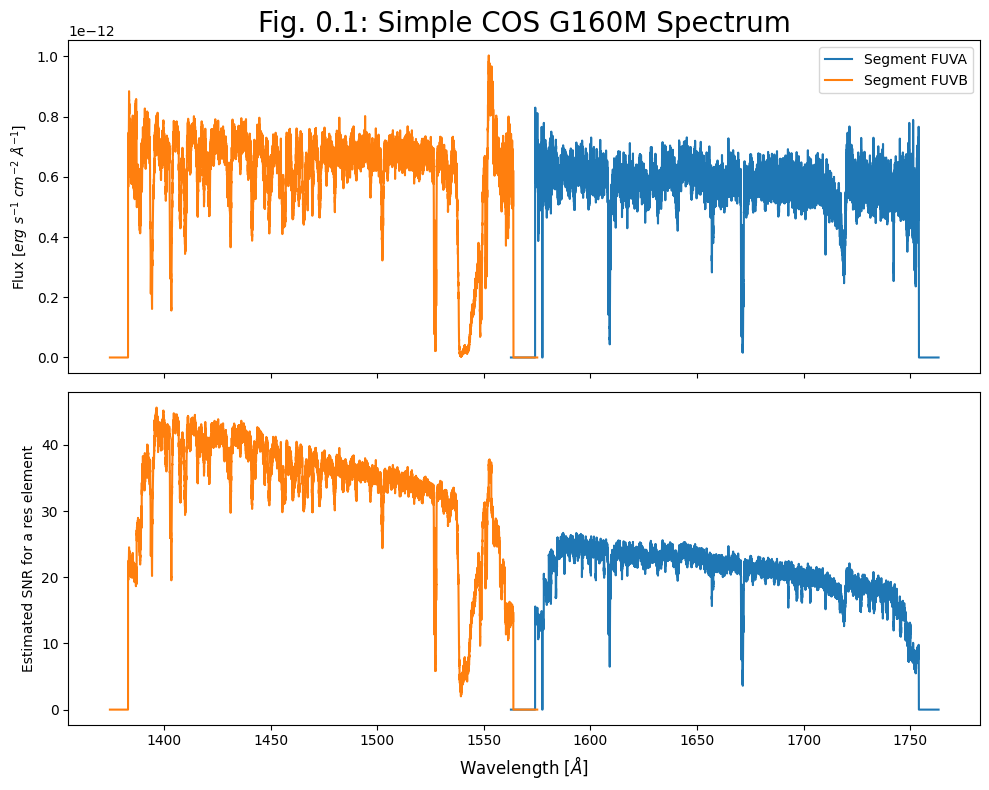

In [1]:
# This cell condenses the key material of the Notebook into a single cell

# 1. Import the necessary libraries:
from astropy.table import Table
from astropy.io import fits
from astroquery.mast import Observations
from cos_functions import estimate_snr
import matplotlib.pyplot as plt

# 2. Download an example dataset using astroquery:
# For more information, see the "Downloading your data" Notebook
onecell_x1dsum_dataprod = Observations.download_products(
    # Filtering through data products, only downloading X1DSUM files.
    Observations.filter_products(
        # Getting a list of data products for the given observation
        Observations.get_product_list(
            # Searching for objects in MAST
            Observations.query_criteria(
                # The Obs ID of the observation to download
                obs_id="LDM701020"
            )
        ),
        # Only downloads the 1 dimensional extracted spectrum
        productSubGroupDescription="X1DSUM"
    )
)

# 3. Read in the data to an Astropy Table:
x1dsum_data_table = Table.read(
                        onecell_x1dsum_dataprod["Local Path"][0])

# Some users may be familiar with another way to read FITS table data:
with fits.open(onecell_x1dsum_dataprod["Local Path"][0]) as hdulist:
    alternate_x1dsum_data_structure = hdulist[1].data

# 4. Estimate the SNR of the spectrum by calculating sqrt(counts):
#    The `estimate_snr` function is defined `cos_functions.py`
SNR_estimate = estimate_snr(
                    x1dsum_data_table,
                    binsize_=6,
                    verbose=False)

# 5. Create a plot of the spectrum and the estimated S/N:
# 2 subplots, populate the top one with flux and the lower with S/N:
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(10, 8),
                               sharex=True,
                               dpi=100)

for i, segment_row in enumerate(x1dsum_data_table):
    # In the upper panel, plot the spectrum as Flux over Wavelength:
    ax0.plot(segment_row["WAVELENGTH"], segment_row["FLUX"],
             label=f"Segment FUV{'AB'[i]}")
    # In the lower panel, plot SNR as estimated S/N over Wavelength:
    ax1.plot(SNR_estimate[1][i][0], SNR_estimate[1][i][1],
             label=f"Segment FUV{'AB'[i]}")

# The next lines will format the plot and save
ax0.legend()

# Adds a title of fontsize 20 points
ax0.set_title(r"Fig. 0.1: Simple COS G160M Spectrum",
              size=20)
# Adds y axis label to the top panel
ax0.set_ylabel(r'Flux [$erg\ s^{-1}\ cm^{-2}\ \AA^{-1}$]',
               size=10)
# Adds y axis label to the bottom panel
ax1.set_ylabel(r'Estimated SNR for a res element',
               size=10)
# Adds x axis label to the bottom panel
ax1.set_xlabel(r'Wavelength [$\AA$]',
               size=12)

# Removing whitespace in figure
plt.tight_layout()
# Saving figure as PNG
plt.savefig("./Fig_0.1_quick_plot.png")

### Now, returning to our more detailed walkthrough
#### Notes for those new to `Python`/Jupyter/Coding:

- You will frequently see exclamation points (**\!**) or dollar signs (**\$**) at the beginning of a line of code we are telling you to run. These are not part of the actual commands. The exclamation points tell a Jupyter Notebook to pass the following line to the command line, and the dollar sign merely indicates the start of a terminal prompt. 

<font size="4"> We will import the following packages:</font>

- `numpy` to handle array functions (version $\ge$ 1.17)
- `pathlib` for managing system paths.
- `astropy.io fits` for accessing FITS files
- `astropy.table Table` for creating tidy tables of the data
- `astropy.units` and `astropy.visualization.quantity_support` for dealing with units
- `matplotlib.pyplot` for plotting data
- `astroquery.mast Observations` for finding and downloading data from the [MAST](https://mast.stsci.edu/portal/Mashup/Clients/Mast/Portal.html) archive

The line `%matplotlib inline` causes `matplotlib` plots to appear in the Notebook instead of possibly showing up in separate windows. Additionally, `quantity_support()` supports plotting `astropy` units in `matplotlib`.

*Later on, we will import some functions from a local file*, `cos_functions.py`, which is installed as part of the same GitHub repository as this Notebook. If you do not see this `Python` file in this directory, you can find it [here](https://github.com/spacetelescope/hst_notebooks/tree/main/notebooks/COS/ViewData). `cos_functions.py` must be installed next to this Notebook (`ViewData.ipynb`).

In [2]:
from astroquery.mast import Observations
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from astropy.table import Table
from astropy.io import fits
from astropy.visualization import quantity_support
from astropy import units as u

%matplotlib inline
quantity_support()

<astropy.visualization.units.quantity_support.<locals>.MplQuantityConverter at 0x7ff346d7b3d0>

<font size="4"> We will also define a few directories in which to place our data and plots, as well as a few colors we will use in plots later.</font>

In [3]:
# These are the paths for important directories for this Notebook
datadir = Path('./data')
outputsdir = Path('./output/')
plotsdir = Path('./output/plots')

# Make the directories if they don't exist
datadir.mkdir(exist_ok=True)
outputsdir.mkdir(exist_ok=True)
plotsdir.mkdir(exist_ok=True)

# Specifying a few colors to correspond to COS segments for plotting
# by their hex code. Many search engines will show you the hex color
segment_colors = {'FUVA': '#BC8C5B',
                  'FUVB': '#4B6CA4',
                  'NUVA': '#1813CE',
                  'NUVB': '#61946E',
                  'NUVC': '#8C1A11'}

<font size="4">We will be working with some FUV and NUV datasets downloaded in the cell below. </font>


These two datasets contain FUV observations of the QSO *3C48* and NUV observations of the Star *WD1057 + 719*, respectively.

Searching for and downloading data is out of the scope of this tutorial. If you wish to learn more, please see our [tutorial on downloading COS data](https://github.com/spacetelescope/hst_notebooks/blob/main/notebooks/COS/DataDl/DataDl.ipynb).

In [4]:
# Download the _x1dsum and _asn NUV data on WD1057+719 (G230L grating)
nuv_downloads = Observations.download_products(
                        Observations.get_product_list(
                            Observations.query_criteria(
                                obs_id='lbbd01020')),
                        download_dir=str(datadir),
                        extension='fits',
                        mrp_only=True,
                        cache=False)

# Download the _x1dsum and _asn FUV data on QSO 3C48
fuv_downloads = Observations.download_products(
                        Observations.get_product_list(
                            Observations.query_criteria(
                                obs_id='lcxv13050')),
                        download_dir=str(datadir),
                        extension='fits',
                        mrp_only=True,
                        cache=False)

 [Done]


 [Done]


 [Done]


 [Done]


**If you're confident Reading-in and Plotting data in Python, now go ahead to [Section 3](#AssessingV)**

<a id="readInV"></a>
# 1. Reading in the data

Calibrated COS 1-dimensional spectra are stored in FITS files with the suffix `x1d` or `x1dsum` (*1-dimensional here means that the cross-dispersion axis has been collapsed*). 
`x1d` files contain a spectrum processed from a single exposure, while `x1dsum` files contain summed data from multiple exposures at different fixed pattern noise position settings (FP-POS). You may also encounter `x1dsumN` files, i.e. `x1dsum1`/`x1dsum2`/`x1dsum3`/`x1dsum4`, which are intermediate files containing data from multiple exposures at the same FP-POS. All of these files are sub-types of `x1d` files and thus share the same basic data structure. What you learn with one filetype is transferable to working with another.
We will be working with `x1dsum` files in this tutorial; however, please note that we often use the shorthand "`x1d`" as part of a variable name when programming, regardless of whether it is a summed file or not.

The calibrated spectrum data has been downloaded onto our local machine as: **<`current-working-directory`>**`/data/mastDownload/HST/`**<`Obs_id`>**`/`**<`Obs_id`>**`_x1dsum.fits`,
where the NUV and FUV Data are contained in the `obs_ids`:

| Spectral Region | Obs_id| Object Name|Object Type|filepath|
|-----|------------|------|-----------|--------|
| FUV | LCXV13050|QSO| 3C48 |  ./data/mastDownload/HST/lcxv13050|
| NUV | LBBD01020|Star| WD1057 + 719 |  ./data/mastDownload/HST/lbbd01020|

<a id="investV"></a>
## 1.1. Investigating the Data - *Basics*
We want to learn the basics about this file, then read in the data.
Reading the file's primary FITS header gives us information about its data, as shown in the below cell.


In [5]:
# Make sure these filepath variables point to your new FUV data
# We'll often refer to the x1dsum file with the prefix x1d
# However, the files are x1dsum files, not the related x1d files
fuv_x1d_filepath = Path(
                    './data/mastDownload/HST/lcxv13050'
                    + '/lcxv13050_x1dsum.fits')

# The association file; the COS calibration pipeline (CalCOS)
# uses this file to process spectra
fuv_asn_filepath = Path(
                    './data/mastDownload/HST/lcxv13050'
                    + '/lcxv13050_asn.fits')

# Make sure these point to your new NUV data
nuv_x1d_filepath = Path(
                    './data/mastDownload/HST/lbbd01020'
                    + '/lbbd01020_x1dsum.fits')
# This is the NUV association file
nuv_asn_filepath = Path(
                    './data/mastDownload/HST/lbbd01020'
                    + '/lbbd01020_asn.fits')

# Here we get the FITS headers for our NUV/FUV x1d & asn files
nuv_x1d_header = fits.getheader(nuv_x1d_filepath)
nuv_asn_header = fits.getheader(nuv_asn_filepath)

fuv_x1d_header = fits.getheader(fuv_x1d_filepath)
fuv_asn_header = fits.getheader(fuv_asn_filepath)

# This is the primary, 0th header of the calibrated FUV spectrum;
fuv_x1d_header[:18], "...", fuv_x1d_header[45:53]
# This is *not* the whole header!
# The [:18] and [45:53] tell Python
# to print the first 18 lines and lines 45-53

(SIMPLE  =                    T / conforms to FITS standard                      
 BITPIX  =                    8 / array data type                                
 NAXIS   =                    0 / number of array dimensions                     
 EXTEND  =                    T                                                  
 NEXTEND =                    1 / Number of standard extensions                  
 DATE    = '2025-03-11'         / date this file was written (yyyy-mm-dd)        
 FILENAME= 'lcxv13050_x1dsum.fits' / name of file                                
 FILETYPE= 'SCI      '          / type of data found in data file                
                                                                                 
 TELESCOP= 'HST'                / telescope used to acquire data                 
 INSTRUME= 'COS   '             / identifier for instrument used to acquire data 
 EQUINOX =               2000.0 / equinox of celestial coord. system             
                

For instance, we notice that the FUV data was taken in [TIME-TAG mode](https://hst-docs.stsci.edu/cosdhb/chapter-5-cos-data-analysis/5-4-working-with-time-tag-data) and calibrated with the COS calibration pipeline, `CalCOS` version `3.4.3` (at the time of writing this sentence - it may have been reprocessed by the time you read this).

However, some metadata information, such as the time of observation and calculated exposure time, can be found in the **1-th header** rather than the 0th. We will read and print this below:

In [6]:
# Opening the FUV X1D file's header and extracting information
with fits.open(fuv_x1d_filepath) as hdu:
    # Opening the 1-th header
    fuv_x1d_header1 = hdu[1].header
    # Getting the date of the observation
    fuv_date = fuv_x1d_header1['DATE-OBS']
    # Getting the start time of the observation
    fuv_time = fuv_x1d_header1['TIME-OBS']
    # Getting the exposure time of the observation
    fuv_exptime = fuv_x1d_header1['EXPTIME']

# Note: You can also access the 1-th extension header using:
#    'fits.getheader(fuv_x1d_filepath, ext=1)'

# Print statement to user with newly-extracted FUV header information
print(
    f"This FUV data was taken on {fuv_date} starting at {fuv_time}"
    f" with a net exposure time of {fuv_exptime} seconds.")

# Now doing the same extraction, but with the NUV X1D file
with fits.open(nuv_x1d_filepath) as hdu:
    nuv_x1d_header1 = hdu[1].header
    nuv_date = nuv_x1d_header1['DATE-OBS']
    nuv_time = nuv_x1d_header1['TIME-OBS']
    nuv_exptime = nuv_x1d_header1['EXPTIME']

# Print statement to the user with newly-extracted NUV header info
print(
    f"This NUV data was taken on {nuv_date} starting at {nuv_time}"
    f" with a net exposure time of {nuv_exptime} seconds.")

This FUV data was taken on 2016-06-13 starting at 23:56:29 with a net exposure time of 6532.512 seconds.
This NUV data was taken on 2009-08-14 starting at 06:03:56 with a net exposure time of 999.136 seconds.


<a id=readmainV></a>
## 1.2. Reading in the `x1d`/`x1dsum` Main Data

The data are in the 1-th header-data unit (HDU) of our FITS file. There are several ways to read in our data from the our table-formatted FITS file. We'll demonstrate three common methods below, focusing in on the [`astropy.table`](https://docs.astropy.org/en/stable/io/unified.html#getting-started-with-table-i-o) method.
We will then display all the fields contained in this data table using the `.colnames` method. You can ignore the warnings about multiple slashes in the units that come up while reading in the data. The proper units are displayed in LaTex as:

- 'erg /s /cm\**2 /angstrom'  ==> $$\ \ erg\ s^{-1}\ cm^{-2}\ \mathring{A}^{-1}$$
- 'count /s /pixel'          ==> $$\ \ counts\ s^{-1}\ pixel^{-1}$$

The columns of these tables include some scalar values which *describe* the data (i.e. `EXPTIME`), while the columns containing actual data hold it in arrays of equal length (i.e. `WAVELENGTH`, `FLUX`, etc., where that length = `NELEM`).

In [7]:
# Method number 1:
with fits.open(fuv_x1d_filepath) as hdulist:
    fuv_x1d_data = hdulist[1].data
print(f"Method 1 gets data as type: {type(fuv_x1d_data)}")

# Method number 2:
fuv_x1d_data = fits.getdata(fuv_x1d_filepath)
print(f"Method 2 gets data as type: {type(fuv_x1d_data)}")

# Method number 3:
fuv_x1d_data = Table.read(fuv_x1d_filepath)
print(f"Method 3 gets data as type: {type(fuv_x1d_data)}")

# We can easily explore this astropy table
columns = fuv_x1d_data.colnames
# Print basic info about the table's columns
print("\nTable of FUV data with columns:\n", columns, "\n")
# Display a representation of the data table:
fuv_x1d_data

Method 1 gets data as type: <class 'astropy.io.fits.fitsrec.FITS_rec'>
Method 2 gets data as type: <class 'astropy.io.fits.fitsrec.FITS_rec'>
Method 3 gets data as type: <class 'astropy.table.table.Table'>

Table of FUV data with columns:
 ['SEGMENT', 'EXPTIME', 'NELEM', 'WAVELENGTH', 'FLUX', 'ERROR', 'ERROR_LOWER', 'GROSS', 'GCOUNTS', 'VARIANCE_FLAT', 'VARIANCE_COUNTS', 'VARIANCE_BKG', 'NET', 'BACKGROUND', 'DQ', 'DQ_WGT'] 



SEGMENT,EXPTIME,NELEM,WAVELENGTH,FLUX,ERROR,ERROR_LOWER,GROSS,GCOUNTS,VARIANCE_FLAT,VARIANCE_COUNTS,VARIANCE_BKG,NET,BACKGROUND,DQ,DQ_WGT
,s,,Angstrom,erg / (Angstrom s cm2),erg / (Angstrom s cm2),erg / (Angstrom s cm2),ct / s,ct,ct,ct,ct,ct / s,ct / s,,
bytes4,float64,int32,float64[16384],float32[16384],float32[16384],float32[16384],float32[16384],float32[16384],float32[16384],float32[16384],float32[16384],float32[16384],float32[16384],int16[16384],float32[16384]
FUVA,6532.512,16384,1610.2408333820224 .. 1810.9448636791049,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,128 .. 128,0.0 .. 0.0
FUVB,6532.512,16384,1421.9464241857763 .. 1622.5957869332856,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,128 .. 128,0.0 .. 0.0


**In the case of the FUV data, we see an `astropy` style table of 2 rows** which are labeled FUVA and FUVB. These rows contain data from the 2 segments of FUV Detector (see Figure 1.1).

### Fig. 1.1 from [COS DHB Fig. 1.6](https://hst-docs.stsci.edu/cosdhb/chapter-1-cos-overview/1-2-cos-physical-configuration#id-1.2COSPhysicalConfiguration-Figure1.6)

<center>
    <img src=figures/cosdhb_fig1p6.jpg width ="900" title="Layout of the COS FUV detector">
    <figcaption>Layout of the COS FUV detector. Note that FUVB corresponds to shorter wavelengths than FUVA.</figcaption>
</center>

**In the case of the NUV data, we see a similar `astropy` style table of 3 rows** (labeled NUVA, NUVB, and NUVC). These rows contain data from the 3 stripes of the NUV spectrum (see Figure 1.2).

### Fig. 1.2 from [COS DHB Fig. 1.10](https://hst-docs.stsci.edu/cosdhb/chapter-1-cos-overview/1-2-cos-physical-configuration#id-1.2COSPhysicalConfiguration-Figure1.10)

<center>
    <img src=figures/ch1_cos_overview3.10.jpg width ="900" title="An example COS NUV spectrum">
    <figcaption>An example COS NUV spectrum. The spectrum itself, taken with the Primary Science Aperture, is in the lower three stripes labeled 'PSA'. The upper stripes, labeled 'WCA' are for wavelength calibration.</figcaption>
</center>


An important thing to note about this *NUV* data in particular is that with the grating used here (G230L), stripe C is actually a 2nd order spectrum with a higher dispersion and ~5% contamination from the 1st order spectrum. See the [COS Data Handbook](https://hst-docs.stsci.edu/cosdhb/chapter-1-cos-overview/1-1-instrument-capabilities-and-design#id-1.1InstrumentCapabilitiesandDesign-NUVSpectroscopyNUVSpectroscopy) for more information.

<a id=assocV></a>
## 1.3. The Association (`asn`) file

It's also likely we will want to see what observations went into making this calibrated spectrum. This information is contained in the Association (`asn`) file, under the `MEMNAME` column, which can be seen after running the next cell.

In [8]:
# Printing the summary information about the FITS file
print(fits.info(fuv_asn_filepath), '\n\n----\n')
# Getting the asn file data in an astropy table
fuv_asn_data = Table.read(fuv_asn_filepath)
# Printing said table
print(fuv_asn_data)

Filename: data/mastDownload/HST/lcxv13050/lcxv13050_asn.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      43   ()      
  1  ASN           1 BinTableHDU     25   5R x 3C   [14A, 14A, L]   


None 

----

   MEMNAME        MEMTYPE     MEMPRSNT
-------------- -------------- --------
     LCXV13FLQ         EXP-FP        1
     LCXV13FXQ         EXP-FP        1
     LCXV13G4Q         EXP-FP        1
     LCXV13GXQ         EXP-FP        1
     LCXV13050        PROD-FP        1


We see that our data has `MEMTYPE` = `PROD-FP`, meaning it is an output science product (see COS DHB [Table 2.6](https://hst-docs.stsci.edu/cosdhb/chapter-2-cos-data-files/2-4-cos-data-products#:~:text=Figure%202.6%3A%20FITS%20File%20Format%20for%201%2DD%20Extracted%20Spectrum%20Table.).)

This particular association file lists four `EXP-FP` (input science exposure), with the `MEMNAME` values (Dataset IDs) `[LCXV13FLQ, LCXV13FXQ, LCXV13G4Q, LCXV13GXQ]`. We could look for these datasets, if we wished to inspect the exposures individually.

### Exercise 1.1. *Finding Metadata for the NUV*
1. Read in the NUV data, just as we did with the FUV data.
2. From the 0th header of the `x1dsum` file, determine the time (in MJDs) that the data was processed. (keyword = `PROCTIME`) and from the 1th header, determine how many wavelength calibration "flashes" were used (keyword = `NUMFLASH`)
3. From the `asn` file, determine how many input science exposures went into the NUV `x1dsum` file.

In [9]:
# Your code here

<a id="plottingV"></a>
# 2. Plotting the Data

<a id = plotdataFUV></a>
## 2.1 Plotting an FUV Spectrum
In [Section 1.2](readmainV), we read in our `x1d` and `x1dsum` files' data using the three different method. By working with the rows and columns of our table, we can plot our spectrum as wavelength vs flux for each segment. 

<a id = firstplotFUV></a>
### 2.1.1 Our First Plot
Our table has two rows: the first for Segment A and the second for Segment B. We'll demonstrate how to plot the data for Segment A first. We can specify the row we're interested in using the index of the row (an integer); our columns can be accessed in a similar manner, using the column name of interest (which will be a string). 

Below, we use the form `our_table[ROW]["COLUMN"]` to access our data but you could just as easily use `our_table["COLUMN"][ROW]` instead. *Note that there is a difference in speed between the two. `astropy` recommends using the second form since the code will not create an intermediate `Row` object.*

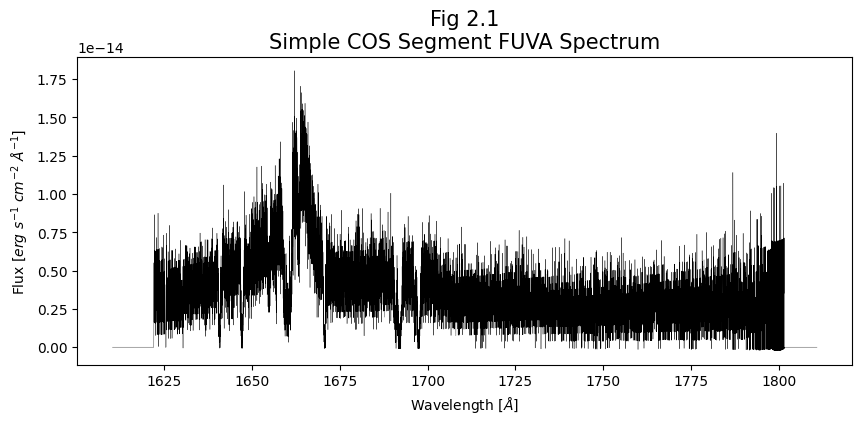

In [10]:
# Access FUVA data
wvln = fuv_x1d_data["WAVELENGTH"][0]
flux = fuv_x1d_data["FLUX"][0]
segment = fuv_x1d_data["SEGMENT"][0]

# Set up the plot as a single box with a figure size of 10x4 inches,
# and with a dpi of 100 (dpi = px per inch).
# The first two params here correspond to the num of rows/cols,
# they're both 1 here since we're plotting a single
# plot but this is going to be useful when we work
# with multiple subplots.
fig, ax = plt.subplots(1, 1, figsize=(10, 4),
                       dpi=100)

##############
# Here we plot wavelength vs flux:
# The x and y values for our plot, wavelength and flux here
ax.plot(wvln, flux,
        # This sets the thickness for the plot line
        linewidth=0.25,
        # Here we're setting the color of the line
        c='black')

##############
# We're adding the labels and title to the plot now:
# Setting the x-axis label
ax.set_xlabel(r'Wavelength [$\AA$]')
# Setting the y-axis label
ax.set_ylabel(r'Flux [$erg\ s^{-1}\ cm^{-2}\ \AA^{-1}$]')

# Adding the title to the plot and putting
# the FUV segment from the FITS header in the title too
ax.set_title('Fig 2.1\nSimple COS Segment ' + segment + ' Spectrum',
             size=15)

# Now we can save the figure to our plots directory
plt.savefig(str(plotsdir / "Fig2.1.png"))

# We can show the figure below once the cell is run
plt.show()

### Exercise 2.1: A clearer plot
Plot the data from Segment FUVB, similar to the Segment FUVA plot above.

Note what can you simply copy over, and what you have to make sure to change.

In [11]:
# Your code here

<a id = plotcompV></a>
### 2.1.2. A Complex Look at the Entire FUV

**Now that we have an idea for how `matplotlib` works, let's make a more complicated graph showing both FUV segments - *independently and together*.**

One of the most important steps to creating a plot is planning out how it will look and convey its information. We'll begin by planning this out below:

|Panel|Contents|Information Conveyed|Notes|
|-|-|-|-|
|*top*|Entire FUV Spectrum as a **simple plot**|Overview of the entire spectrum we have, coarse look without much detail|Color by segment|
|*middle*|Shorter Wavelength FUVB Spectrum as an **errorbar plot**|Closer look at the shorter wavelength spectrum with an idea of error|Color errorbar by segment, central line in black|
|*bottom*|Longer Wavelength FUVA Spectrum as an **errorbar plot**|Closer look at the longer wavelength spectrum with an idea of error|Color errorbar by segment, central line in black|

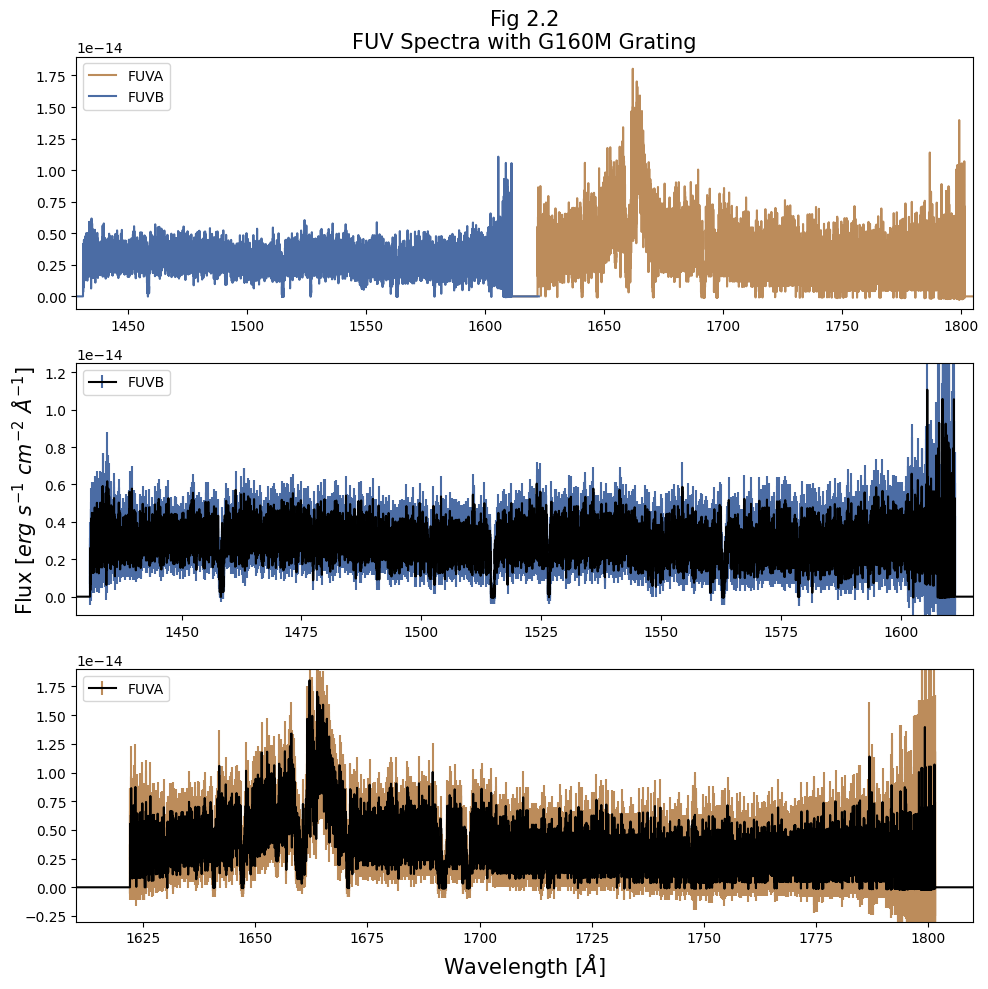

In [12]:
# ax0, ax1, ax2 are our 3 vertically-aligned panels,
# which are top, middle, and bottom.
# "fig" is the entire figure, which consists of the three subplots.
# Here we have 3 rows, 1 column, figure size of 10x10 inches
fig, (ax0, ax1, ax2) = plt.subplots(3, 1, figsize=(10, 10))

# Repeats for i=[0,1] to apply to each segment's data at a time
for i in range(2):
    # Selects all useful data for the chosen segment
    wvln, flux = fuv_x1d_data["WAVELENGTH", "FLUX"][i]
    fluxErr, segment = fuv_x1d_data["ERROR", "SEGMENT"][i]

    # This section applies the top panel's plotting and formatting:
    # Plotting wavelength vs flux:
    ax0.plot(wvln, flux,
             # Labeling our plot with its segment (used in legend)
             label=segment,
             # Getting the segment color for FUV/NUV A/B
             c=segment_colors[segment])

    # Formatting the plot in the next few cells:
    # Getting a legend for our plot, located in the upper left
    ax0.legend(loc='upper left')
    # Setting the title of the plot. "size" here is our fontsize
    ax0.set_title("Fig 2.2\nFUV Spectra with G160M Grating",
                  size=15)
    # Setting the limit for the x axis; ax.set_xlim(START, END)
    ax0.set_xlim(1428, 1805)
    # Setting the limits for the y axis; ax.set_ylim(START, END)
    ax0.set_ylim(-1E-15, 1.9E-14)

    ######
    # Indented code applies only to segment FUVA data in bottom panel
    if i == 0:
        # Plotting wavelength vs flux, with y axis error (flux)
        ax2.errorbar(x=wvln, y=flux,
                     yerr=fluxErr,
                     label=segment,
                     c='black',
                     # Setting the color of our errorbars
                     ecolor=segment_colors[segment])

        ax2.set_xlim(1610, 1810)
        ax2.set_ylim(-3E-15, 1.9E-14)
        # Putting our legend in the upper left portion of the plot
        ax2.legend(loc='upper left')
        ax2.set_xlabel(r'Wavelength [$\AA$]',
                       size=15)

    # Plotting with errorbars for the FUVB data, similar to FUVA plot
    # This indented code applies only to FUVB data in middle panel
    if i == 1:
        ax1.errorbar(x=wvln, y=flux,
                     yerr=fluxErr,
                     label=segment,
                     c='black',
                     ecolor=segment_colors[segment])

        ax1.set_xlim(1428, 1615)
        ax1.set_ylim(-1E-15, 1.25E-14)
        ax1.legend(loc='upper left')
        ax1.set_ylabel(r'Flux [$erg\ s^{-1}\ cm^{-2}\ \AA^{-1}$]',
                       size=15)

# Clipping the whitespace of the figure
plt.tight_layout()
# Saving our figure to the plots directory
plt.savefig(str(plotsdir / 'Fig2.2.png'),
            dpi=200)
# Showing our figure below once we run the cell
plt.show()

<a id = plotcloserV></a>
### 2.1.3. Looking Closer at Parts of the FUV Spectrum

**It can be very difficult to get any insights on small-scale details in the above plots because data is too dense to parse at once. Below, we'll show examples of:**
- Plotting a small region around an absorption line feature.
- Plotting an entire segment's spectrum in segments of wavelength space.

**Let's begin with showing a region around a line, in this case, we see a sharp line around 1670 Å.** 

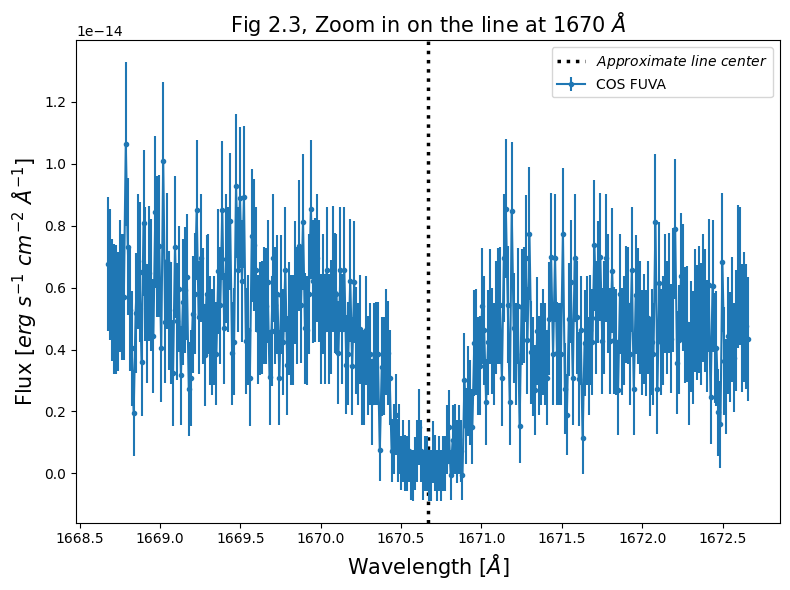

In [13]:
# By-eye center of the line for plotting
line1670 = 1670.67

# Selects all useful data for the chosen segment
wvln, flux = fuv_x1d_data["WAVELENGTH", "FLUX"][0]
fluxErr, segment = fuv_x1d_data["ERROR", "SEGMENT"][0]

# How many Angstroms in each direction around line 1670 do we want to look at?
wvln_extent = 2

# Mask the data to within +/- wvln_extent Angstrom of the line
lineRegion_mask = (wvln > line1670 - wvln_extent)\
                  & (wvln < line1670 + wvln_extent)

# Applies the created mask so we get data from our desired wavelength range
wvln_region = wvln[lineRegion_mask]
flux_region = flux[lineRegion_mask]
fluxErr_region = fluxErr[lineRegion_mask]

# Setting the size of the plot, in inches
plt.figure(figsize=(8, 6))

# Creating a verticle line on the plot
plt.axvline(x=line1670,
            c='black',
            linewidth=2.5,
            # Setting the style of the line
            linestyle='dotted',
            label=r'$Approximate\ line\ center$')

plt.errorbar(x=wvln_region, y=flux_region,
             # Plotting an error bar
             yerr=fluxErr_region,
             # Labeling errorbar for legend
             label='COS FUVA',
             # Setting the marker for the errorbar
             marker='.')

plt.xlabel(r'Wavelength [$\AA$]', size=15)
plt.ylabel(r'Flux [$erg\ s^{-1}\ cm^{-2}\ \AA^{-1}$]',
           size=15)
plt.title(r'Fig 2.3, Zoom in on the line at 1670 $\AA$',
          size=15)

plt.legend()
plt.tight_layout()
# Saving the figure to plots directory
plt.savefig(str(plotsdir / 'Fig2.3.png'),
            dpi=200)

The source we're looking at - the quasar 3C48 has a substantial redshift: $$z \approx 0.37$$  

Source: [Simbad search for 3C48](http://simbad.u-strasbg.fr/simbad/sim-basic?Ident=3c48&submit=SIMBAD+search)

With that redshift, we can determine the rest-frame wavelength.

$$z = \dfrac{\lambda_{obs}-\lambda_{rest}}{\lambda_{rest}} \ \ \rightarrow\ \ \ \lambda_{rest} = \dfrac{\lambda_{obs}}{1+z}$$

At that redshift, we see this line to be $\approx 1219$ Å. This is close to, and may correspond to, the Lyman-$\alpha$ transition.

<font size="4"><b>Now we will create a much more complex plot,</b></font> <font size="3">allowing us to visualize an entire segment's spectrum in fine detail</font>

We'll split the spectrum into "segments" of \~10 Angstroms, and plot these segments in a vertical series. These plots may take a minute to create. If you want them to run quicker, hit the `Interrupt the Kernel` square-shaped button to stop the current cell from running (you will get an error message), and run this cell with a smaller number of rows (`nRows`).
<a id="fig2p4V"></a>

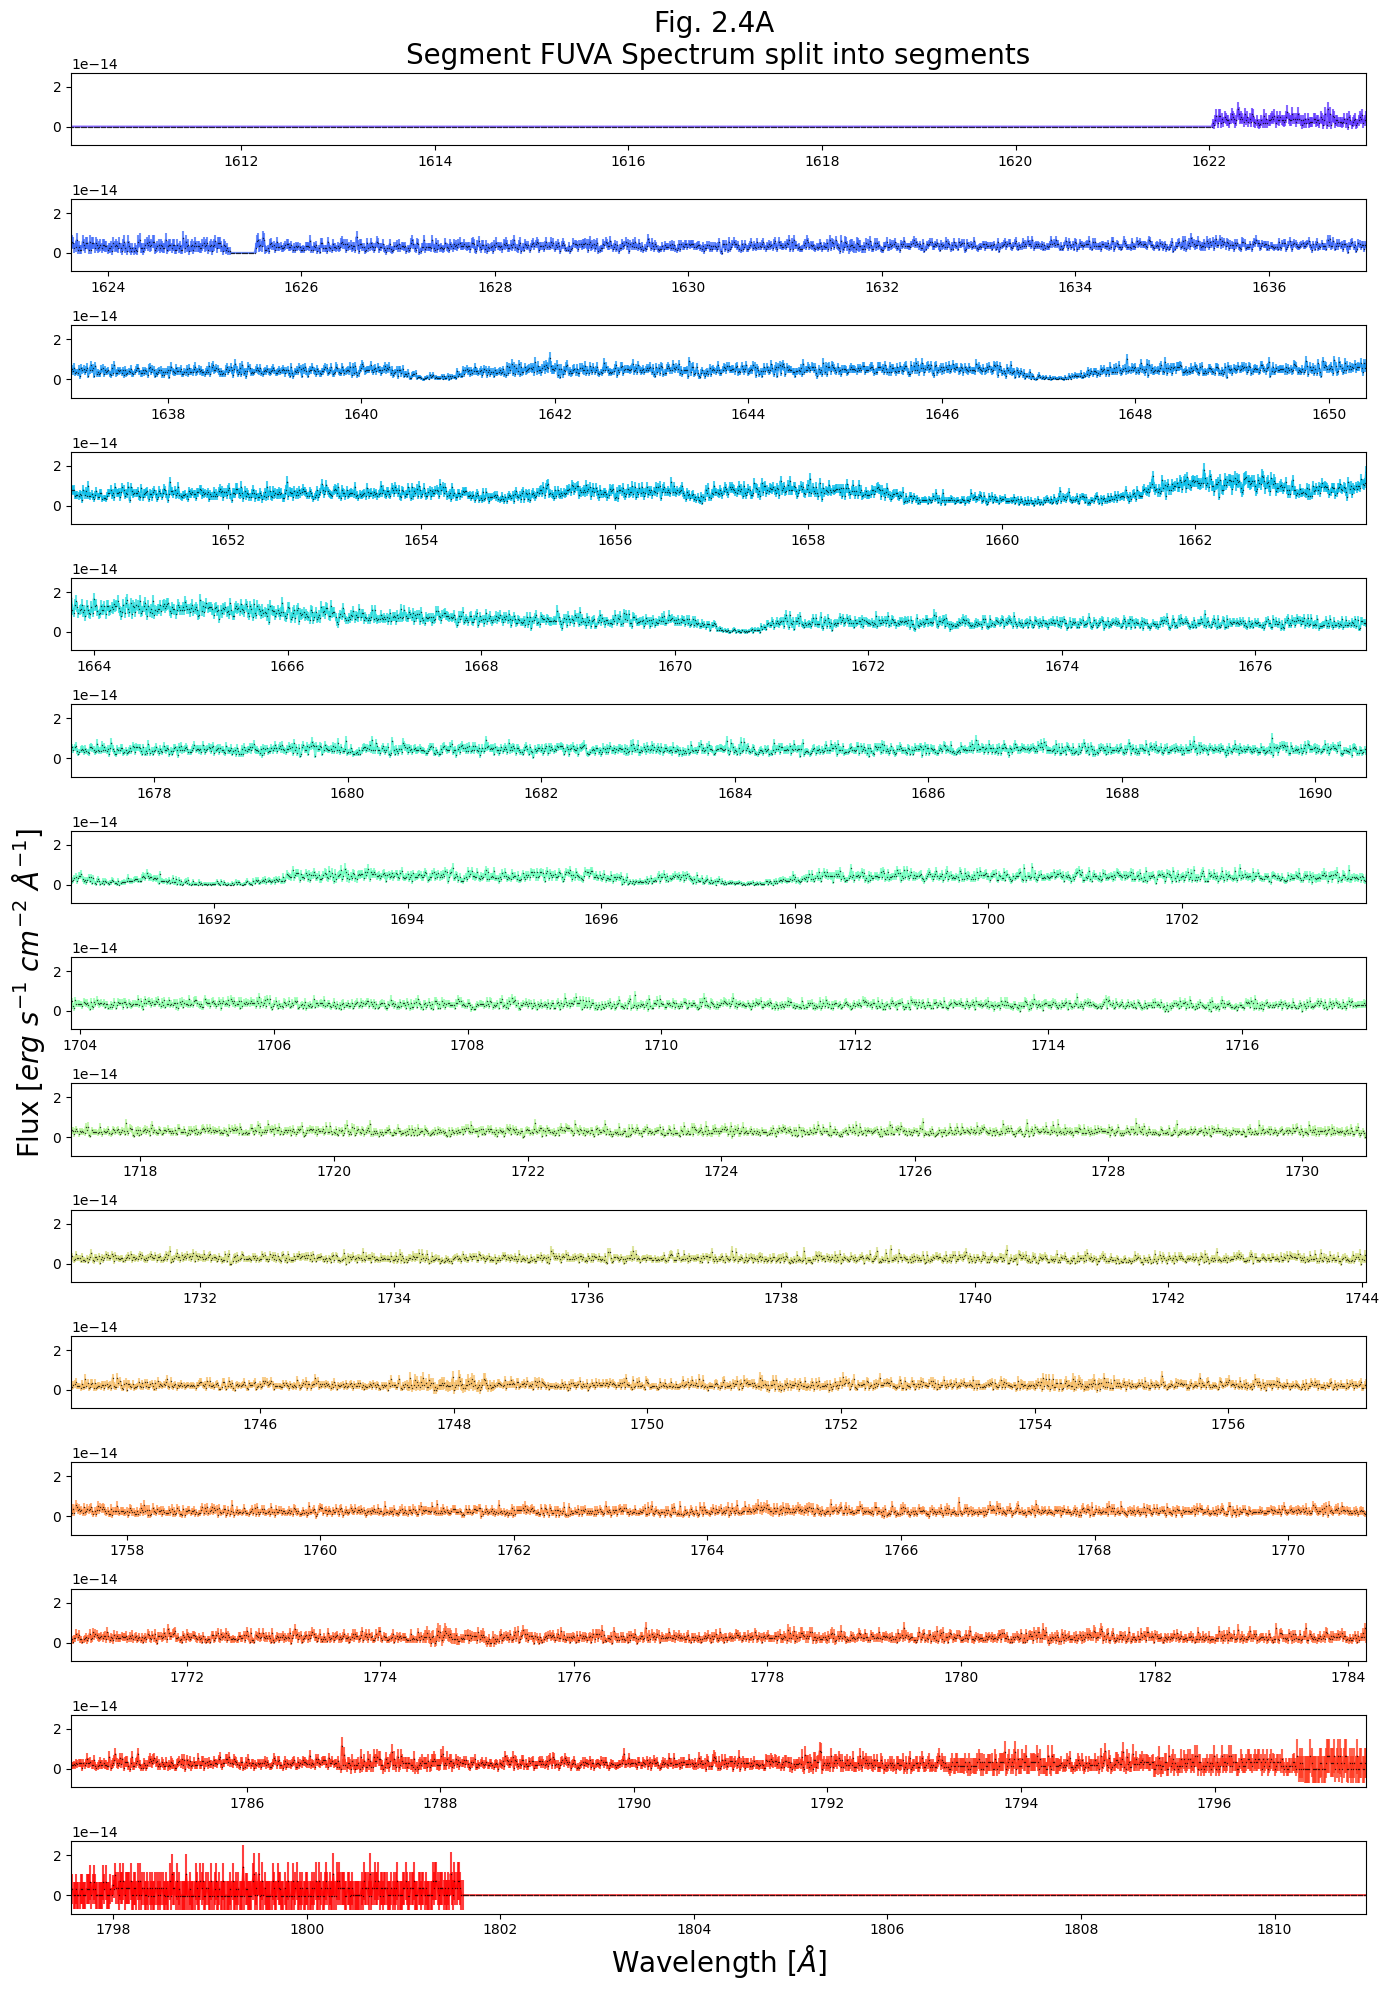


----



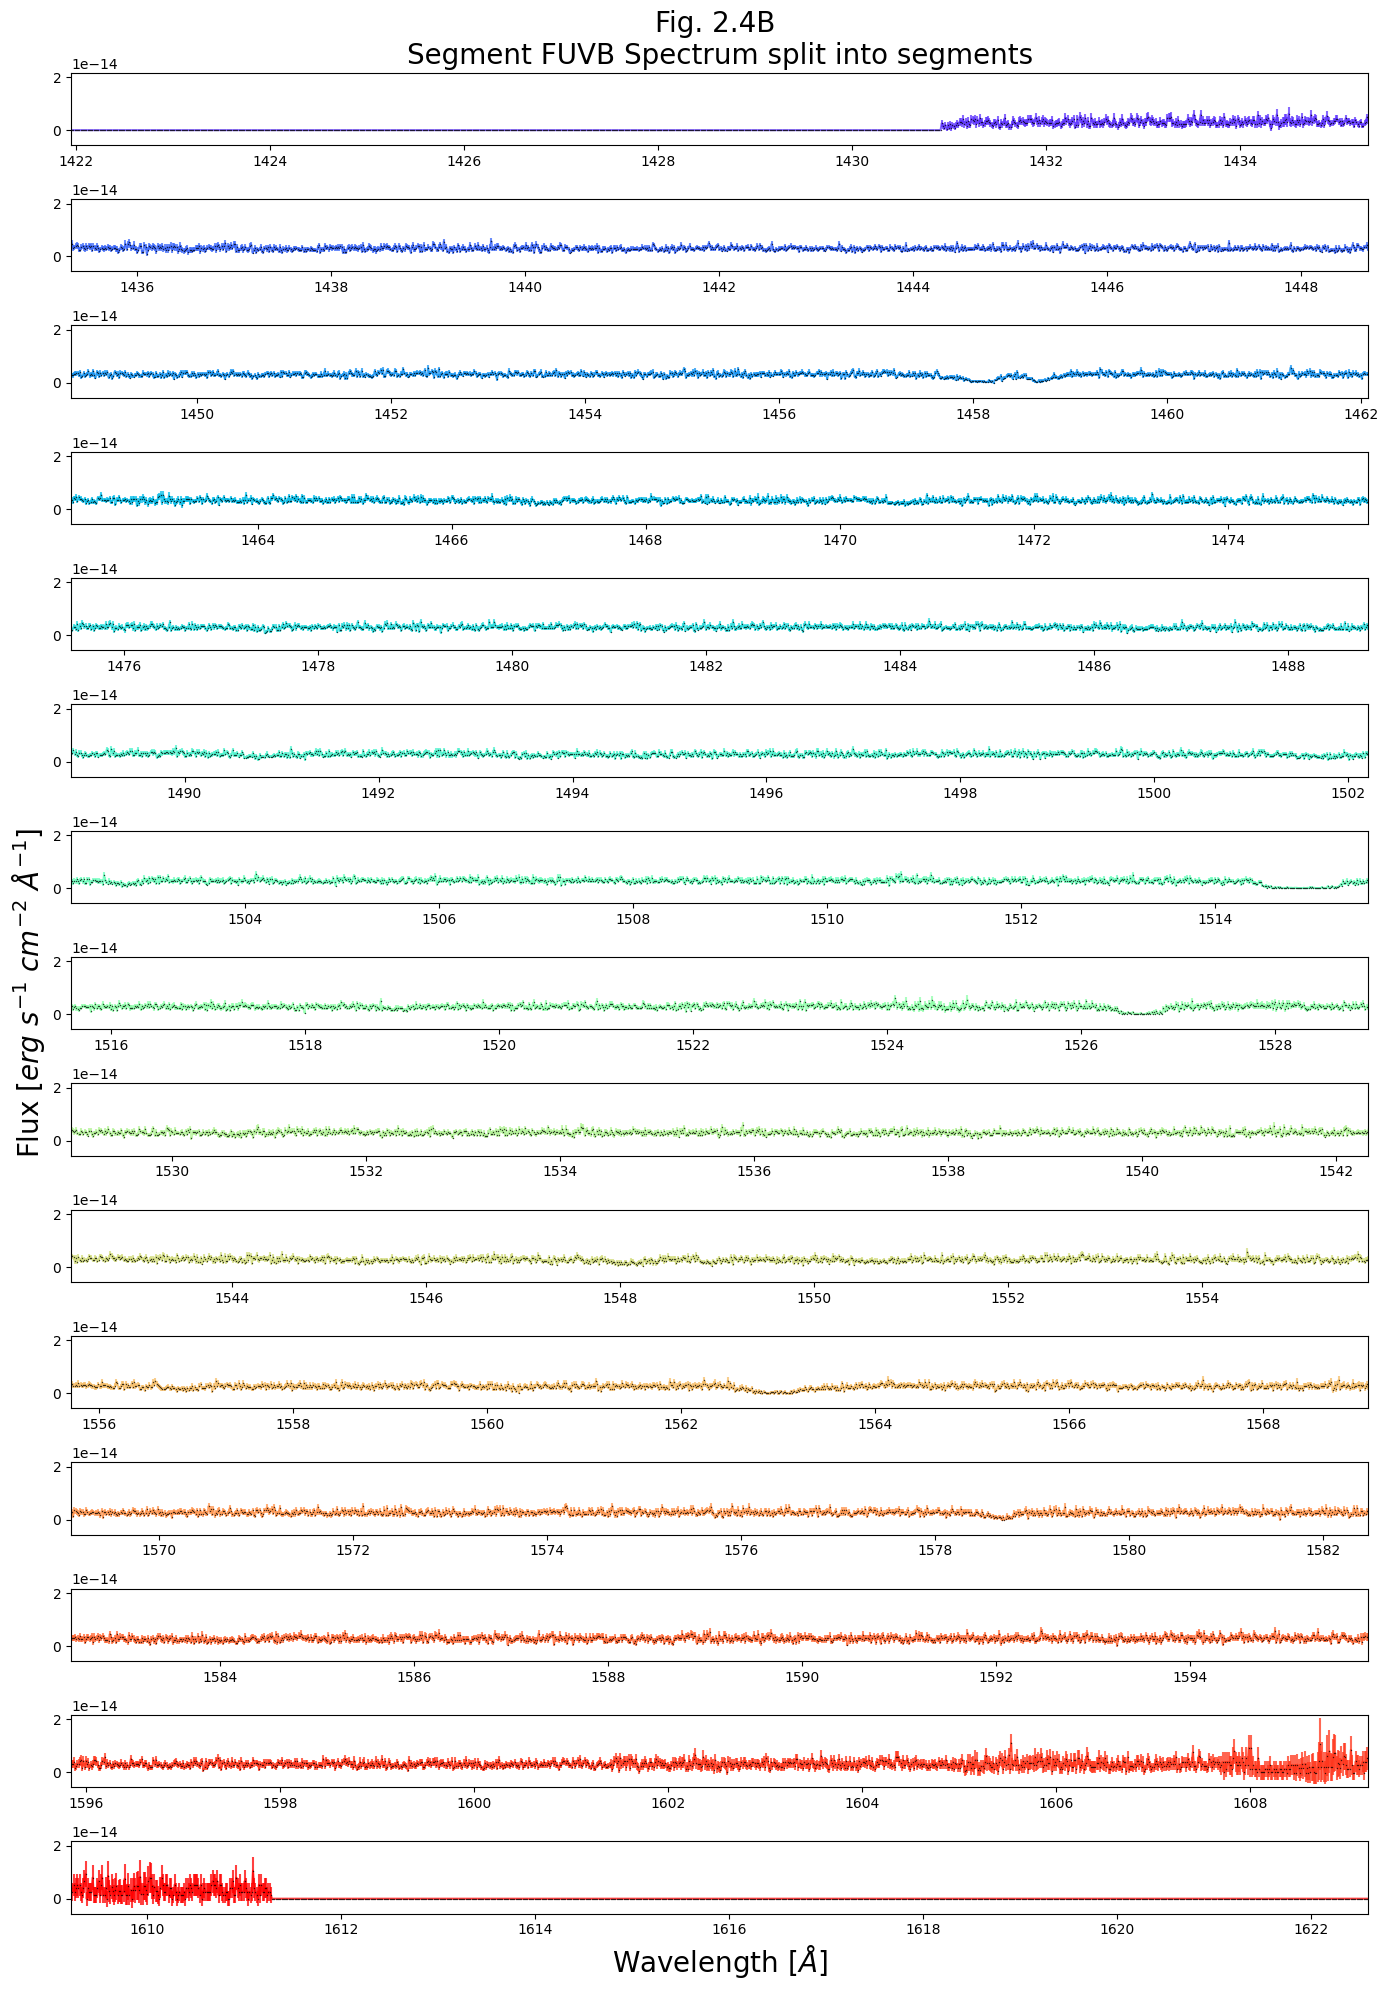


----



In [14]:
# Apply the following to each segment's data at a time
for segment_row in fuv_x1d_data:
    # Selects all immediately useful data for the chosen segment
    wvln, flux = segment_row['WAVELENGTH', 'FLUX']
    fluxErr, segment = segment_row['ERROR', 'SEGMENT']

    # Getting the min and max wavelength and flux values for segment
    minx, maxx = min(wvln), max(wvln)
    miny, maxy = min(flux), max(flux)
    # Getting the wavelength range for segment
    rangex = maxx - minx

    fig = plt.figure(figsize=(14, 20))

    # How many segments we wish to split the spectrum into
    nRows = 15

    # Going through each segment and plotting its wavelength range
    for i in range(nRows):
        # Getting the min and max wavelength range for this segment
        min_ = minx + i * rangex / nRows
        max_ = minx + (i + 1) * rangex / nRows

        # Creating a subplot for this segment
        ax = plt.subplot(nRows, 1, i + 1)

        # Set the title, xlabel, and ylabel, independent of # of rows:
        if i == 0:
            ax.set_title(
                f'Fig. 2.4{segment[-1]} \nSegment {segment} '
                'Spectrum split into segments',
                size=20)

        if i == nRows - 1:
            ax.set_xlabel(r'Wavelength [$\AA$]',
                          size=20)

        if i == int(nRows / 2):
            ax.set_ylabel(r'Flux [$erg\ s^{-1}\ cm^{-2}\ \AA^{-1}$]',
                          size=20)

        # Creating the plot itself:
        # Plotting wavelength vs flux, with flux error
        ax.errorbar(wvln, flux, fluxErr,
                    c=plt.cm.rainbow((i + 1) / nRows),
                    # Setting the transparency
                    alpha=0.75,
                    marker='.',
                    markerfacecolor='black',
                    # Setting the size of the marker
                    markersize=2,
                    mew=0)

        ax.set_xlim(min_, max_)

    plt.tight_layout()
    plt.savefig(str(plotsdir / f'Fig2.4{segment[-1]}'
                    '_{nRows}Rows_seg{segment}.png'),
                dpi=200)
    plt.show()

    # Printing this line to separate FUVA and FUVB's plots
    print('\n----\n')

### Exercise 2.2 Choosing and plotting a useful data range
That last plot was very dense with information. As practice plotting, make a scaled down version from just `1635 - 1675` Angstroms, and plot the data as a simple line graph.

In [15]:
# Your code here

<a id = specvizV></a>
### 2.1.4. Reading and plotting the data with `specutils` (*OPTIONAL*)
<font size="4.5"> <em>Note, this section is entirely optional, and simply meant to give you more options for how to plot a spectrum.</em></font>

An alternative way to read in and work with spectral data is with the [`specutils` package](https://specutils.readthedocs.io/en/stable/), which contains *quite a bit of functionality* for working with spectra. It also can make dealing with units easier, as it generally works well with astropy units and other modules. Make sure that your package is up to date (version $\ge$ 1.1). We describe installing `specutils` in our [Notebook on setting up an environment](https://github.com/spacetelescope/hst_notebooks/blob/main/notebooks/COS/Setup/Setup.ipynb).

`specutils` treats spectra as special python objects rather than lists, and reads in the entire spectrum over both segments. 

Below is a simple example of using `specutils` to read-in, plot, and continuum-normalize our entire spectrum.

        Use Spectrum instead. [astropy.io.registry.core]
        Use Spectrum instead. [specutils.spectra.spectrum]


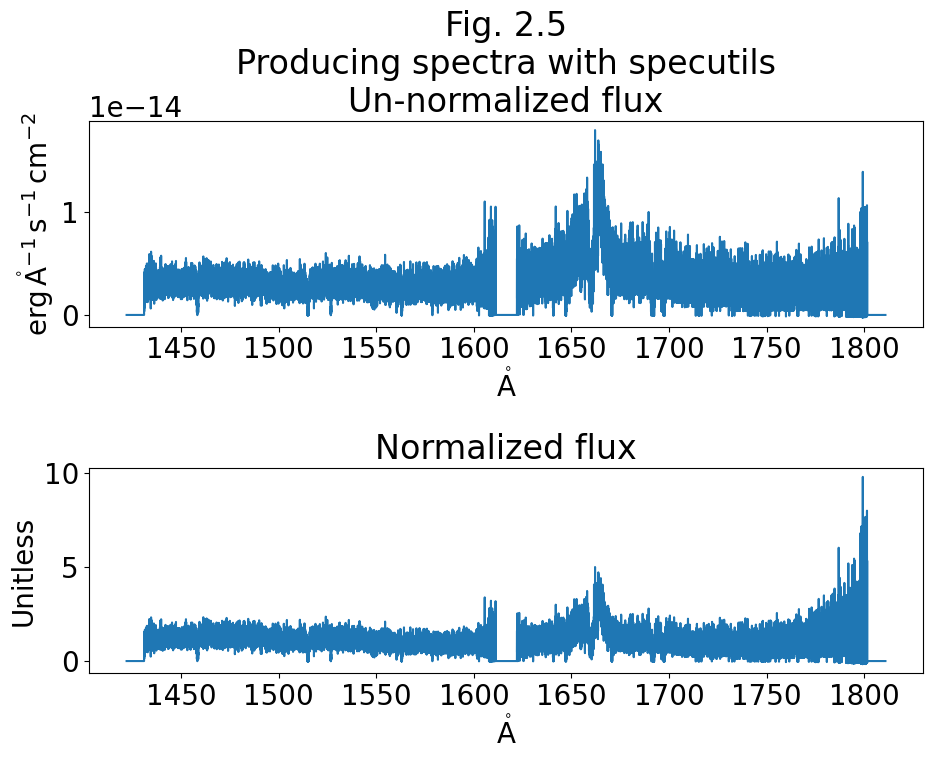

In [16]:
import specutils
from specutils.fitting import fit_generic_continuum

from matplotlib import rcParams

# The default fontsize it will use does not be clear at this plot size
rcParams.update({'font.size': 20})

# Here we're getting the entire spectrum (FUVA & FUVB)
spec1d = specutils.Spectrum1D.read(fuv_x1d_filepath)

# 2 rows, 1 column of subplots, 10x8 in. figure
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(10, 8))

# Plot the non-normalized flux
# Wavelength vs non-normalized flux
ax0.plot(spec1d.spectral_axis, spec1d.flux)
ax0.set_title("Fig. 2.5\nProducing spectra with "
              + "specutils\nUn-normalized flux")

# Continuum Normalize the flux:
cont_norm_spec1d = spec1d /\
                   fit_generic_continuum(spec1d)(spec1d.spectral_axis)

# Plot the normalized flux and setting the title and y axis label
ax1.plot(cont_norm_spec1d.spectral_axis, cont_norm_spec1d.flux)
ax1.set_title("Normalized flux")
ax1.set_ylabel("Unitless")


plt.tight_layout()
plt.savefig(str(plotsdir / 'Fig2.5.png'),
            dpi=200)

plt.show()

# Not necessary for this plot, but gives us all the data separately
wvln, flux = spec1d.wavelength, spec1d.flux
fluxErr = spec1d.uncertainty.quantity
# Restore default fontsize
rcParams.update({'font.size': 10})

`specutils` also works with the visualization [package `Jdaviz.Specviz`](https://github.com/spacetelescope/jdaviz), to produce very useful interactive spectral plots within a Jupyter Notebook GUI framework. Currently, this interactive program works well within the Jupyter Notebook environment, but not within Jupyter Lab environment. 


<a id=nuvV></a>
## 2.2. Plotting an NUV Spectrum

The NUV data is formatted very similarly to the FUV data, and can be accessed as in [Section 1](#readInV).

In [17]:
# Here we read in the data
# We may ignore warnings about slashes in the notation
nuv_x1d_data = Table.read(nuv_x1d_filepath)

<a id = nuv1V></a>
### 2.2.1. Examining the first-order spectrum

**Again, let's select the simplest data we need to plot a spectrum: WAVELENGTH, FLUX, and ERROR**.

We will limit this first plot to only our first order spectra (we will exclude stripe C). We will plot these two spectra together (in the top panel) and then stripe-by-stripe in the lower 2 panes, similar to Figure 2.2.
- The former view gives a better sense of the continuum
- The latter views show zooms which allow us to meaningfully view the errors and see specific emission/absorption features.

The way we produce this plot with `Python` in the cell below is looping through both NUV first-order stripes - NUVA and NUVB - plotting both of them in the upper subplot, and plotting each of them once more in one of the lower two subplots.

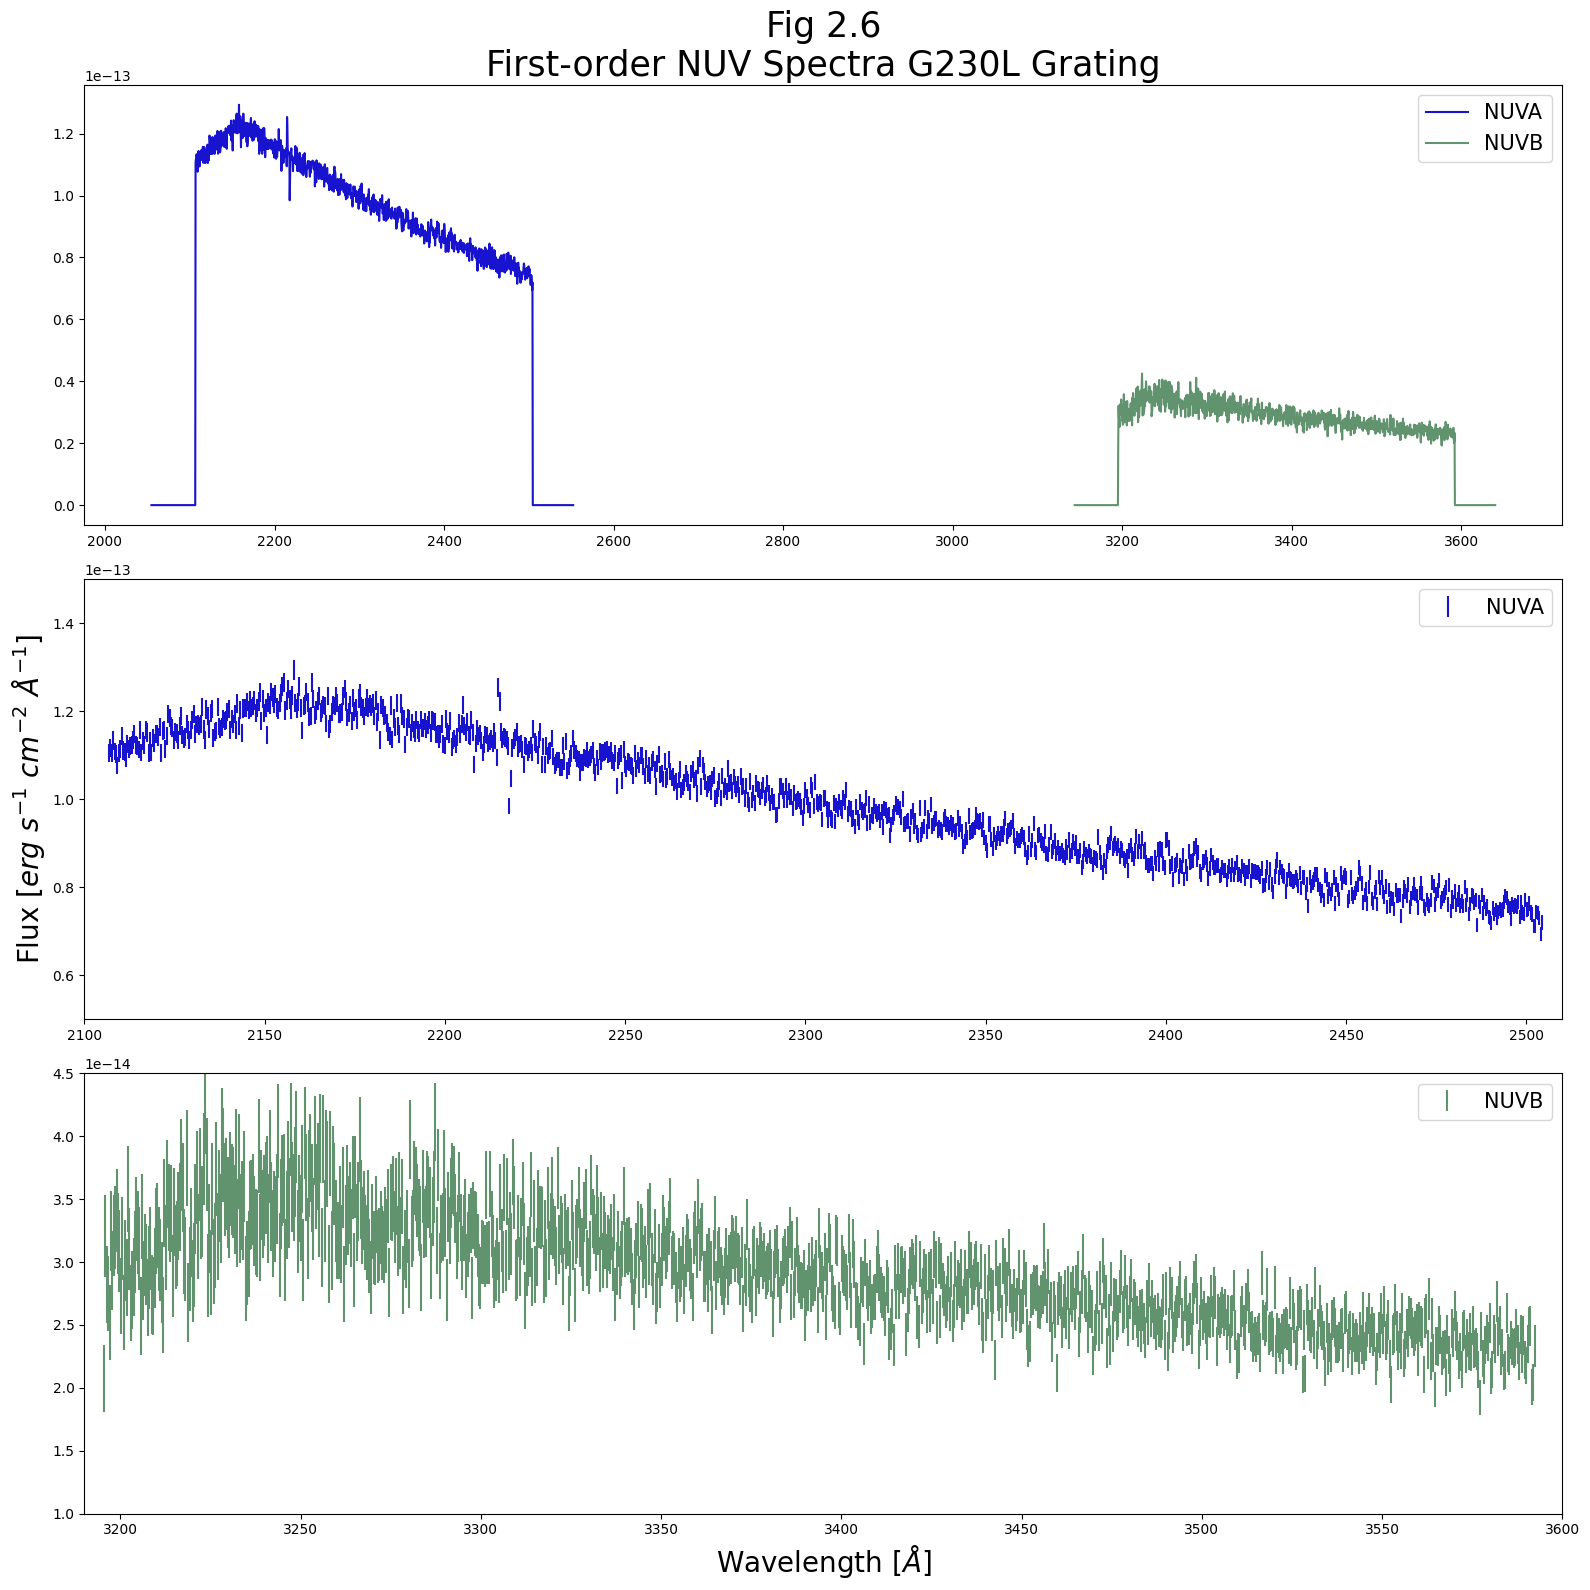

In [18]:
# Build a 3row x 1column - subplot figure
fig, (ax0, ax1, ax2) = plt.subplots(3, 1, figsize=(16, 16))

# Iterate through the first 2 NUV segments/stripes
for i in range(2):
    # Gathering the data
    wvln = nuv_x1d_data[i]["WAVELENGTH"]
    flux = nuv_x1d_data[i]["FLUX"]
    fluxErr = nuv_x1d_data[i]["ERROR"]
    segment = nuv_x1d_data[i]["SEGMENT"]

    ax0.plot(wvln, flux,
             label=segment,
             c=segment_colors[segment])

    ax0.legend(fontsize=15)
    ax0.set_title("Fig 2.6\nFirst-order NUV Spectra G230L Grating",
                  size=25)

    # Plot only 0th segment/stripe in 2nd panel
    if i == 0:
        # Plotting wavelength vs flux with errorbars
        ax1.errorbar(x=wvln, y=flux,
                     yerr=fluxErr,
                     # Linestyle is "" because only plotting fluxErr
                     linestyle="",
                     label=segment,
                     c=segment_colors[segment])

        ax1.set_xlim(2100, 2510)
        ax1.set_ylim(0.5E-13, 1.5E-13)
        ax1.legend(fontsize=15)
        ax1.set_ylabel(r'Flux [$erg\ s^{-1}\ cm^{-2}\ \AA^{-1}$]',
                       size=20)

    # Plot only 1th segment/stripe in 3rd panel, similar to above plot
    if i == 1:
        ax2.errorbar(x=wvln, y=flux,
                     yerr=fluxErr,
                     linestyle="",
                     label=segment,
                     c=segment_colors[segment])

        ax2.set_xlim(3190, 3600)
        ax2.set_ylim(1E-14, 4.5E-14)
        ax2.legend(fontsize=15)
        ax2.set_xlabel(r'Wavelength [$\AA$]',
                       size=20)

plt.tight_layout()
plt.savefig(str(plotsdir / 'Fig2.6.png'),
            dpi=200)

plt.show()

<a id = nuv2V></a>
### 2.2.2. Examining the second-order spectrum

On NUV stripe C data taken with the grating G230L, we have a more dispersed, second-order spectrum over a smaller segment of the NUV. Below, we plot this second-order over the first-order spectrum from stripe A.

Note that most NUV gratings produce first-order spectra over all three stripes. See the [COS Instrument Handbook](https://hst-docs.stsci.edu/cosihb/chapter-5-spectroscopy-with-cos/5-1-the-capabilities-of-cos#id-5.1TheCapabilitiesofCOS-Section5.1.35.1.3Second-OrderSensitivity) for more information. We chose to plot this this type of spectrum to create a more complex plot and to demonstrate using different scales on the same axis.

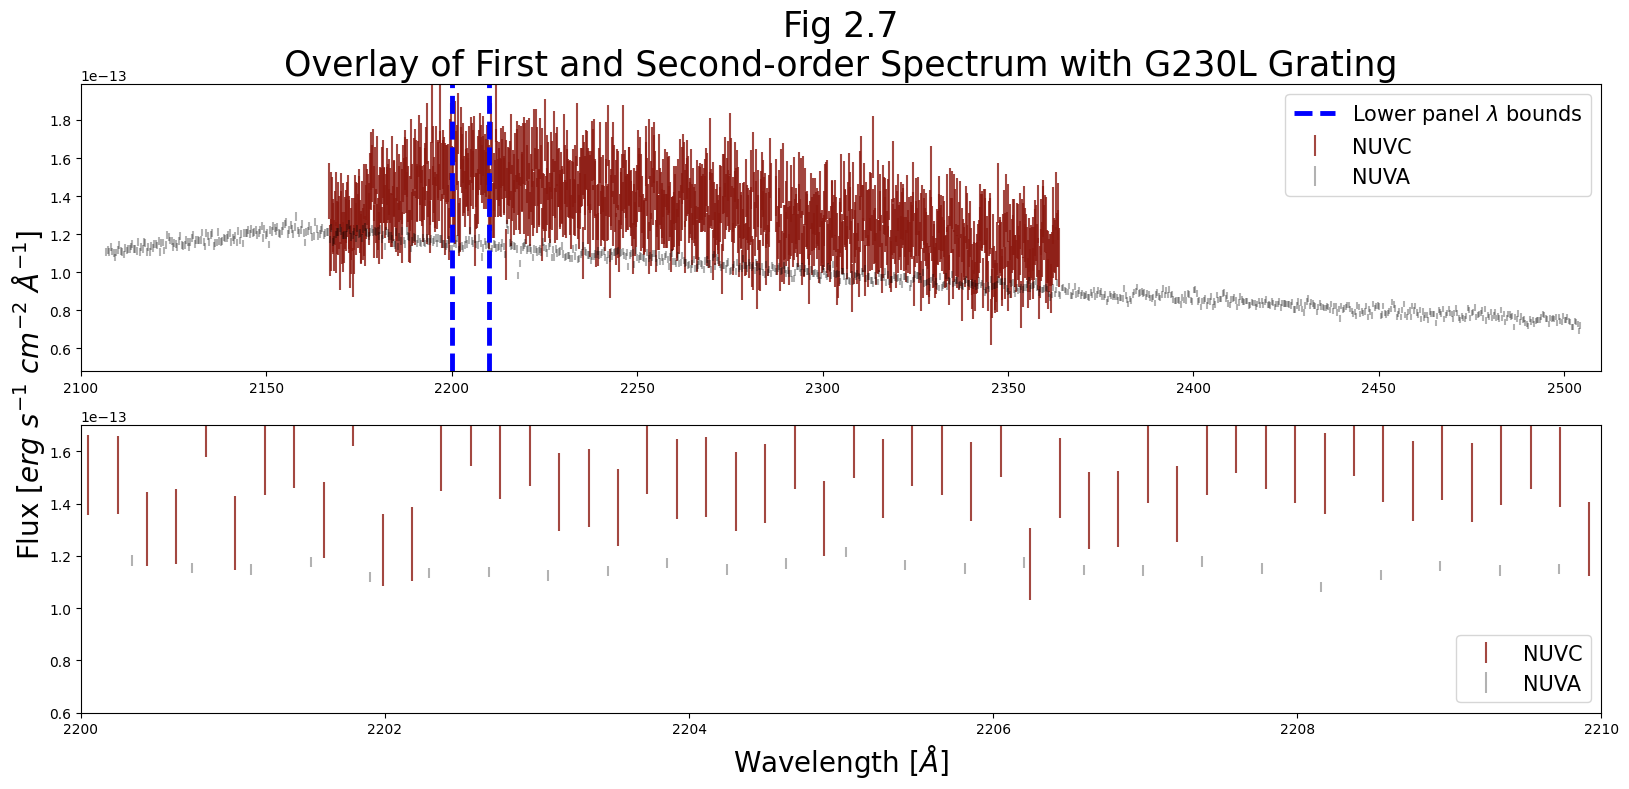

In [19]:
# Creating a figure with 2 subplots:
# 2 rows, 1 column, size 16x8 inches
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(16, 8))

# We reverse this order. The 0th stripe (A) is plotted OVER the 2nd stripe (C)
for i in [2, 0]:
    # Gathering the data for our NUV stripe
    wvln = nuv_x1d_data['WAVELENGTH'][i]
    flux = nuv_x1d_data['FLUX'][i]
    fluxErr = nuv_x1d_data['ERROR'][i]
    segment = nuv_x1d_data['SEGMENT'][i]

    # This is for NUVA stripe
    if i == 0:
        ax0.errorbar(x=wvln, y=flux,
                     yerr=fluxErr,
                     linestyle="",
                     label=segment,
                     c='black',
                     alpha=0.3)

        ax1.errorbar(x=wvln, y=flux,
                     # Plotting errorbars for NUVA bottom plot
                     yerr=fluxErr,
                     linestyle="",
                     label=segment,
                     c='black',
                     alpha=0.3)

    # This is for NUVC stripe data, same style parameters as the NUVA
    # segment but different values for those parameters
    if i == 2:
        ax0.errorbar(x=wvln, y=flux,
                     yerr=fluxErr,
                     linestyle="",
                     label=segment,
                     c=segment_colors[segment],
                     alpha=0.8)

        ax1.errorbar(x=wvln, y=flux,
                     yerr=fluxErr,
                     linestyle="",
                     label=segment,
                     c=segment_colors[segment],
                     alpha=0.8)

# Setting the top plot's x and y axis limits
# These are wavelength and flux respectively
ax0.set_xlim(2100, 2510)
ax0.set_ylim(0.48E-13, 1.99E-13)

# Creating a title for the overall plot
ax0.set_title('Fig 2.7\nOverlay of First and ' +
              'Second-order Spectrum with G230L Grating',
              size=25)

# Setting the x and y axis limits for the bottom plot
ax1.set_xlim(2200, 2210)
ax1.set_ylim(0.6E-13, 1.7E-13)

# Setting the x axis label for the plots
ax1.set_xlabel(r'Wavelength [$\AA$]',
               size=20)

# Creating text for the figure that is the y axis text of both plots
# Coordinates for text box, actual text
fig.text(-0.015, 0.5,
         r'Flux [$erg\ s^{-1}\ cm^{-2}\ \AA^{-1}$]',
         size=20,
         va='center',
         # Specifying rotation
         rotation='vertical')

# Adding 2 vertical lines to show wavelength bounds on the subplot
# Leftmost line at 2200 angstroms
ax0.axvline(2200,
            label=r'Lower panel $\lambda$ bounds',
            linewidth=3.5,
            linestyle='--',
            c='blue')

# Rightmost line at 2210 angstroms
ax0.axvline(2210,
            linewidth=3.5,
            linestyle='--',
            c='blue')

ax0.legend(fontsize=15, loc='upper right')
ax1.legend(fontsize=15, loc='lower right')

plt.tight_layout()
plt.savefig(str(plotsdir / 'Fig2.7.png'),
            dpi=200)
plt.show()

**Clearly, our errorbars on the second-order spectrum (NUVC) are *much larger*.**

However, if we need a very high dispersion - for instance, to split closely-spaced lines - the lower panel shows a potential advantage of stripe C. Its higher spectral sampling rate can allow for finer distinctions in wavelength, *if* an acceptable SNR can be reached.

<a id = AssessingV></a>
# 3. Preliminary Review of the Data

<font size="4"><b>There is no one-size-fits-all approach to analyzing COS data.</b></font>

This section aims to walk you through taking a brief critical look at your data by taking the first steps of [binning](https://en.wikipedia.org/wiki/Data_binning) the data, (to the size of COS' resolution elements - called [resels](https://hst-docs.stsci.edu/cosihb/chapter-3-description-and-performance-of-the-cos-optics/3-2-size-of-a-resolution-element)), and then measuring the Signal-to-Noise Ratio ([SNR](https://en.wikipedia.org/wiki/Signal-to-noise_ratio)).


*Note that the cell below is only necessary if you have chosen to skip Sections \#1 and \#2*

In [20]:
# Make sure these point to your new FUV data
fuv_x1d_filepath = './data/mastDownload/HST/lcxv13050'\
                    '/lcxv13050_x1dsum.fits'
fuv_x1d_data = Table.read(fuv_x1d_filepath)

# Make sure these point to your new NUV data
nuv_x1d_filepath = './data/mastDownload/HST/lbbd01020'\
                    '/lbbd01020_x1dsum.fits'
nuv_x1d_data = Table.read(nuv_x1d_filepath)

<a id = DataQualV></a>
## 3.1. Data Quality and Initial Cleanup

One of the first things one notices in all of the plots we have made is that all of the segments and stripes have real, useful data, bookended on each side by zeros (see, for example, Fig. 2.1).
These zeros are regions on the active area of the detector which don't receive and detect light, but *are* read in as data. We don't want these datapoints in our spectra, so we will filter them out. 

The COS data we have downloaded conveniently have an extension devoted to data quality information. Information on the data quality array and the flags it contains can be found in [COS Data Handbook](https://hst-docs.stsci.edu/cosdhb/chapter-2-cos-data-files/2-7-error-and-data-quality-arrays).

Let's first look at the data quality flags. We'll do this by plotting a histogram, labeling the bins according to what the data quality value of that bin means. We add hatching to the histograms to make it easier to see where certain segments overlap.

/tmp/ipykernel_2769/2395070808.py:47: RuntimeWarning: divide by zero encountered in log2
  logDQ = np.log2(dataQual)
/tmp/ipykernel_2769/2395070808.py:80: RuntimeWarning: divide by zero encountered in log2
  logDQ = np.log2(dataQual)


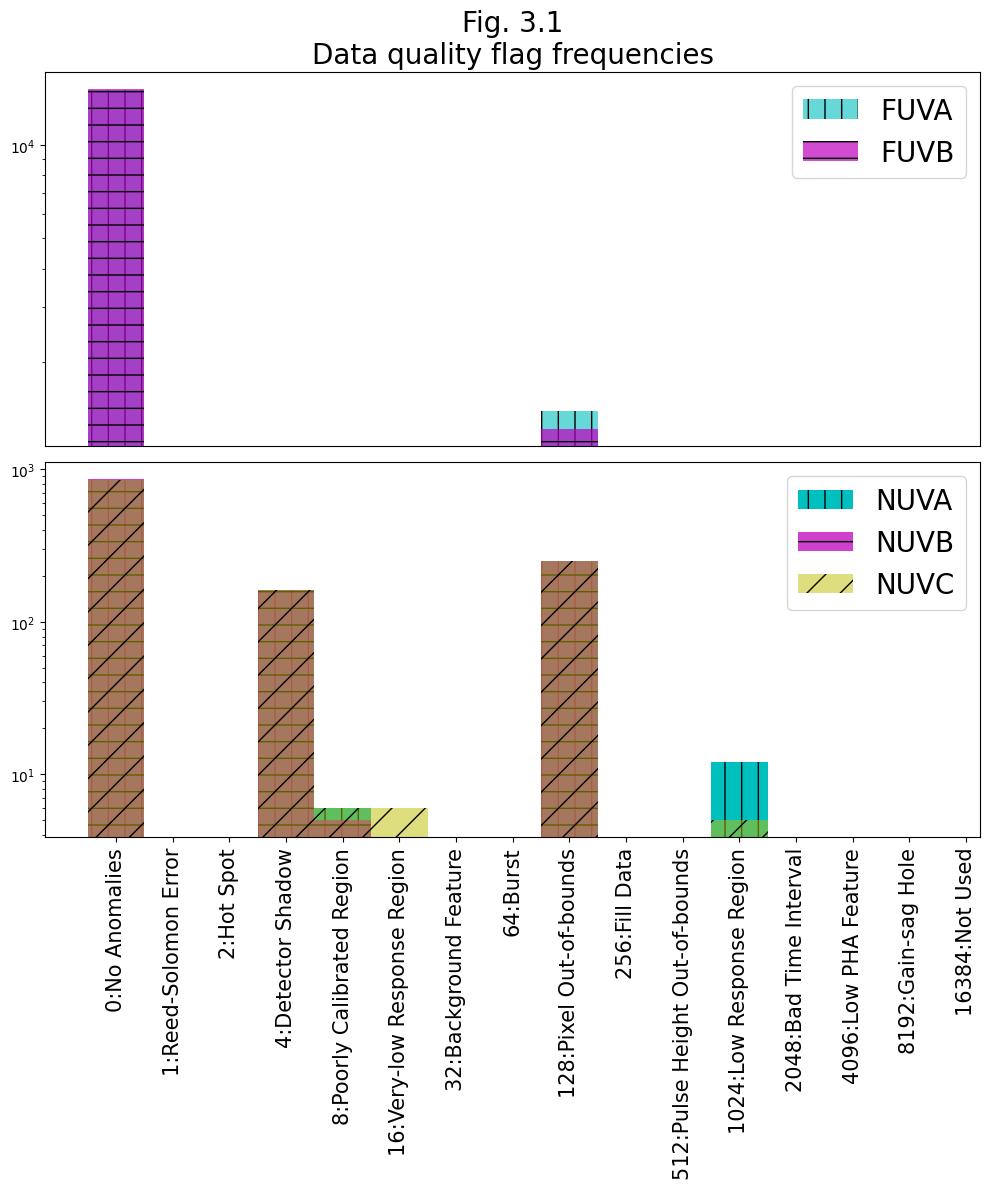

In [21]:
# To make plotting the bins linearly work,
# we deal with the base2 logs of the power-of-2 data quality values

# The values are all powers of two from 2**1 to 2**14
# The exception is for 0, which is 2**-inf
bins_titles = (np.logspace(-1, 14, 16, base=2, dtype=int))

# These are the data quality flags
meanings = ['No Anomalies',
            'Reed-Solomon Error',
            'Hot Spot',
            'Detector Shadow',
            'Poorly Calibrated Region',
            'Very-low Response Region',
            'Background Feature',
            'Burst',
            'Pixel Out-of-bounds',
            'Fill Data',
            'Pulse Height Out-of-bounds',
            'Low Response Region',
            'Bad Time Interval',
            'Low PHA Feature',
            'Gain-sag Hole',
            'Not Used']

# Pair the meaning with its power of 2 value in a single string
# One line loop
meanings2 = [str(bt)+":"+mn for bt, mn in zip(bins_titles, meanings)]

# For those less familiar with Python, this works to generate meanings2:
# meanings2 = [] # Initialize the meanings2 list
# for i in range(len(meanings)): # Iterate through length of meanings
#     line = str(bins_titles[i]) + ': ' + meanings[i]
#     meanings2.append(line) # Append line to the meanings2 list

# Top (FUV) subplot and bottom (NUV) subplot
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(10, 12))

# First loop through the 2 FUV segments to make the top plot
for i in range(2):
    # Get data quality for current segment
    dataQual = fuv_x1d_data["DQ"][i]
    segment = fuv_x1d_data["SEGMENT"][i]
    # All the log2 of the DQ values
    bins_ = np.arange(-1, 15)
    # Returning base 2 log of dataQual
    logDQ = np.log2(dataQual)
    # Filling neg infinity values with -1
    logDQ = np.nan_to_num(logDQ, neginf=-1)

    # Having there be no x axis ticks for top plot
    ax0.set_xticks([])

    # Add hatching to distinguish overlapping colors.
    # Data, num of bins, color of bin for each segment:
    ax0.hist(logDQ,
             bins=bins_,
             color='cmy'[i],
             alpha=0.5+0.1*(i+1),
             label=segment,
             # First segment has hatch with vertical lines in bin,
             # second has horizontal lines
             hatch='|-'[i])

    ax0.legend(fontsize=20)
    # Setting a scale for the y axis
    ax0.set_yscale('log')
    ax0.set_title("Fig. 3.1\nData quality flag frequencies",
                  fontsize=20)

# Loop through 3 NUV stripes to make bottom plot, similar to FUV plot
for i in range(3):
    # Gather the data
    dataQual = nuv_x1d_data["DQ"][i]
    segment = nuv_x1d_data["SEGMENT"][i]
    # All the log2 of the DQ values
    bins_ = np.arange(-1, 15)

    # Returning base 2 log of dataQual
    logDQ = np.log2(dataQual)
    logDQ[np.where(-1*(logDQ) == np.inf)] = -1

    ax1.hist(logDQ,
             bins=bins_,
             color='cmy'[i],
             alpha=1 - 0.25*(i),
             label=segment,
             # Add hatching to distinguish overlapping colors
             hatch='|-/'[i])

    ax1.legend(fontsize=20)
    ax1.set_yscale('log')

plt.xticks(bins_+0.5,
           # Setting list of x axis tick pos, getting labels ticks
           labels=meanings2,
           rotation='vertical',
           fontsize=15)

fig.set_tight_layout('tight')
plt.savefig(str(plotsdir / 'Fig3.1.png'),
            dpi=200)

When the data is processed through `CalCOS`, it has a summed set of "Serious Data Quality" [SDQ](https://hst-docs.stsci.edu/cosdhb/chapter-3-cos-calibration/3-4-descriptions-of-spectroscopic-calibration-steps) flags attached to it in the form of a single integer between 0 and $2^{15}$. This value is found in the 1-th header as `"SDQFLAGS"`. This can be decomposed into the powers of 2 data flags above, (by showing its binary representation,) and tells the pipeline whether to weight that pixel in that exposure by 0 or 1. These weights are then stored in the `x1d` and `x1dsum` files, in the `"DQ_WGT"` column. The `"DQ_WGT"` value for a given pixel in the `x1dsum` file will then be equal to the number of exposures which went into creating that `x1dsum` file in which no serious data quality flags apply to that pixel.

Below, we first see *which* data quality flags the pipeline considered "serious", and then demonstrate masking out the datapoints assigned a weight of 0.

In [22]:
sdqFlags_fuv = fits.getheader(fuv_x1d_filepath, 1)['SDQFLAGS']

print(
    f'The FUV was processed with SDQFLAGS = {sdqFlags_fuv}, '
    f'which in binary is {bin(sdqFlags_fuv)[2:]}')

print("Thus, the following DQ-flagged data get weighted by 0:\n")

for i, char in enumerate(bin(sdqFlags_fuv)[2:]):
    if char == '1':
        print(f'\t{(2**(i + 1))}\'s place - ', meanings[i + 2])

The FUV was processed with SDQFLAGS = 8346, which in binary is 10000010011010
Thus, the following DQ-flagged data get weighted by 0:

	2's place -  Hot Spot
	128's place -  Pixel Out-of-bounds
	1024's place -  Low Response Region
	2048's place -  Bad Time Interval
	8192's place -  Gain-sag Hole


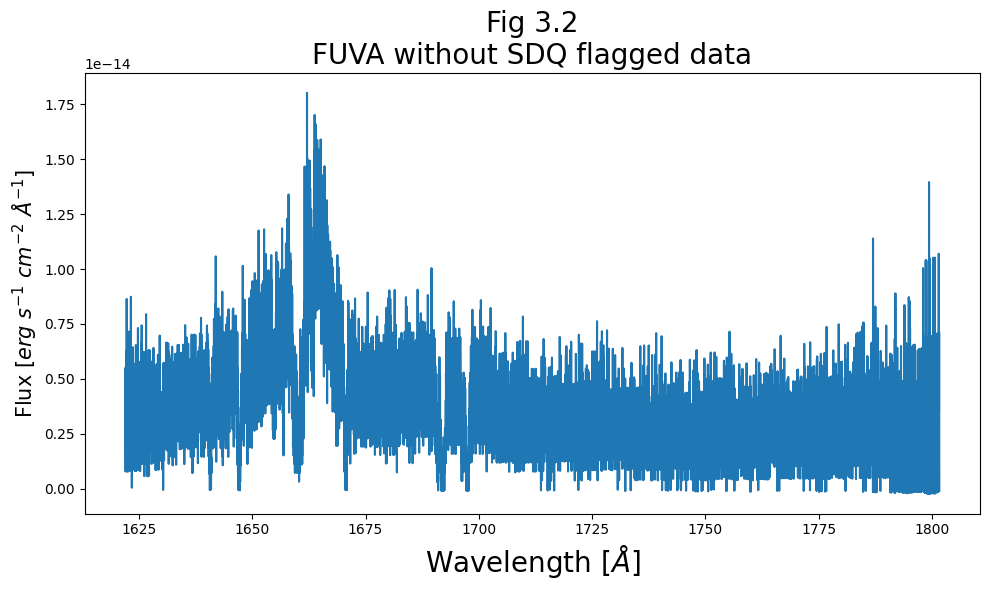

In [23]:
# Filter the datapoints to where there are no serious DQ flags
mask_noSDQ = fuv_x1d_data[0]["DQ_WGT"].astype(bool)

wvln_FUVA_noSDQ = fuv_x1d_data["WAVELENGTH"][0][mask_noSDQ]
flux_FUVA_noSDQ = fuv_x1d_data["FLUX"][0][mask_noSDQ]

# Make the figure
plt.figure(figsize=(10, 6))

# Plot the filtered datapoints
plt.plot(wvln_FUVA_noSDQ, flux_FUVA_noSDQ)

# Format the figure
plt.title("Fig 3.2\nFUVA without SDQ flagged data",
          size=20)
plt.xlabel(r'Wavelength [$\AA$]',
           size=20)
plt.ylabel(r'Flux [$erg\ s^{-1}\ cm^{-2}\ \AA^{-1}$]',
           size=15)

plt.tight_layout()

plt.savefig(str(plotsdir / 'Fig3.2.png'),
            dpi=200)

Alternatively, we can ignore the `SDQFLAGS` and the weights decided by `CalCOS` and pick which data quality flags we want to filter out. From Fig 3.1, we know the only problem in the FUV and the largest problem in the NUV are pixels flagged by **"out of bounds"**, corresponding to Data Quality: **128**.

We will demonstrate removing only these datapoints from the FUV data below. You could also filter to only data with *0: no anomalies*, or to any other subset.

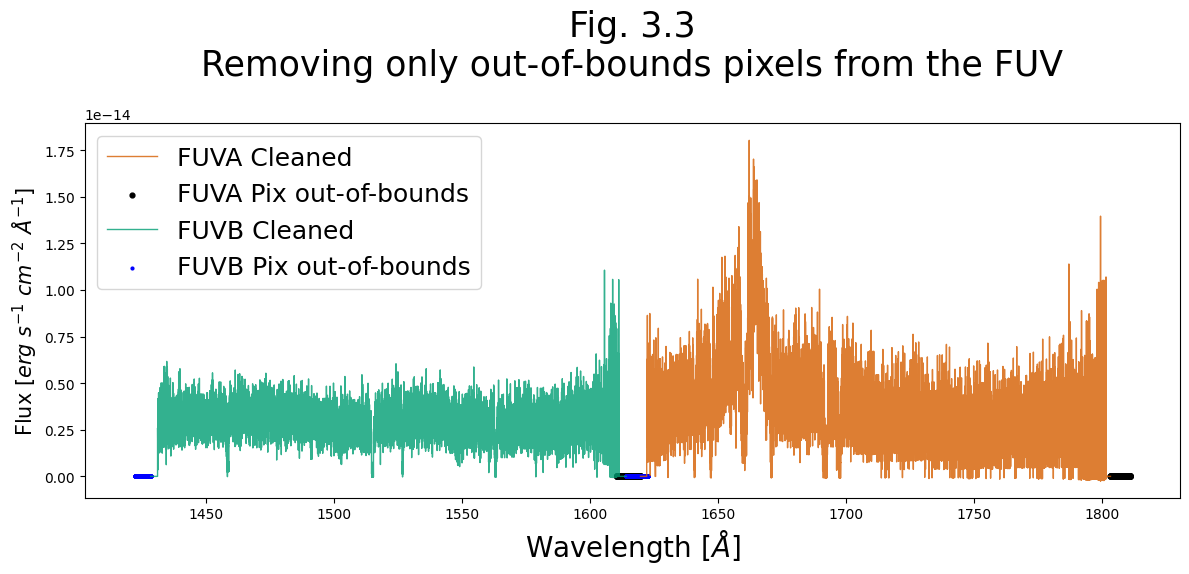

In [24]:
# Creating a plot 12x6 inches with 100 px/in
plt.figure(figsize=(12, 6), dpi=100)

# Going through both FUV segments
for i in range(2):
    # Getting the data from the current segment's x1d file
    wvln = fuv_x1d_data["WAVELENGTH"][i]
    flux = fuv_x1d_data["FLUX"][i]
    fluxErr = fuv_x1d_data["ERROR"][i]
    dataQual = fuv_x1d_data["DQ"][i]
    segment = fuv_x1d_data["SEGMENT"][i]

    # Plotting wavlength vs flux for pixels not out of bounds
    plt.plot(wvln[dataQual != 128.0], flux[dataQual != 128.0],
             linewidth=1,
             alpha=0.8,
             c=['#d55e00', '#009e73'][i],
             label=f"{segment} Cleaned")

    # Plotting a scatter plot for pixels that are out of bounds
    plt.scatter(wvln[dataQual == 128.0], flux[dataQual == 128.0],
                # FUVA: size 12 black markers
                # FUVB: size 4 blue markers
                s=[12, 4][i],
                c=['black', 'blue'][i],
                marker="o",
                label=f"{segment} Pix out-of-bounds")

plt.legend(fontsize=18)

plt.title("Fig. 3.3\nRemoving only out-of-bounds "
          "pixels from the FUV\n",
          size=25)
plt.xlabel(r'Wavelength [$\AA$]',
           size=20)
plt.ylabel(r'Flux [$erg\ s^{-1}\ cm^{-2}\ \AA^{-1}$]',
           size=15)

# Formatting figure and saving
plt.tight_layout()
plt.savefig(str(plotsdir / 'Fig3.3.png'))

### Exercise 3.1: *Removing all flagged data from the NUV*

The NUV data has flags for more than just out-of-bounds pixels.

1. Filter out all data which has been flagged
2. Plot the NUV spectrum from stripes NUVA and NUVB
3. Plot the flagged data in another color to see where the removed data is

In [25]:
# Your answer here

<a id=BinningV></a>
## 3.2. Binning 

Up until now, the data we've been working with has one value per "pixel" of the detector.
COS data is generally binned to a resolution element, or [resel](https://hst-docs.stsci.edu/cosihb/chapter-3-description-and-performance-of-the-cos-optics/3-2-size-of-a-resolution-element), when working with it. These resels are *generally* the following sizes *in pixels*.

||FUV|NUV|
|-|---|---|
|**Dispersion Axis**|6|3|
|**Cross-Dispersion Axis**|10|3|

So, for the FUV, we generally want to preliminarily bin our `x1d` or `x1dsum` data by 6.

<a id=BinfunV></a>
### 3.2.1. Bringing in Some Useful Functions for Binning

In the same subdirectory of the [spacetelescope/hst_notebooks GitHub repository](https://github.com/spacetelescope/hst_notebooks) as this file (`hst_notebooks/COS/ViewData/`), we also have the `Python` file: `cos_functions.py`, in which we have defined several long functions necessary for this data processing. 

*Note, if you downloaded this Notebook file without cloning the entire GitHub repository, you must also download the file `cos_functions.py` from [here](https://github.com/spacetelescope/hst_notebooks/tree/main/notebooks/COS/ViewData)*.

In the cell below, we import the function `bin_by_resel` from the file `cos_functions.py`. The `bin_by_resel` function applies the following binning algorithms to an entire COS NUV or FUV dataset. We run the help function to get more information on how the values are binned.

In [26]:
# Importing cos_functions.py so we can use it in our Notebook
from cos_functions import bin_by_resel
help(bin_by_resel)

Help on function bin_by_resel in module cos_functions:

bin_by_resel(data_table, binsize=6, weighted=True, verbose=True)
    Bins an entire COS dataset (in astropy Table form)
        * Wavelength and flux are combined by taking an exposure-time weighted mean of all the pixels in a bin.
        * Errors are combined as above and divided by the square root of the number of pixels in a bin
        * Counts and count rate are summed over all the pixels in a bin.
    
    Parameters:
    data_table (Table) : Astropy Table of COS spectral data.
    binsize (int) : What to bin by.
    weighted (bool) : Whether to weight the averages by exposure time of a pixel; Default is True.
    verbose (bool) : Whether to print major steps the function is taking; Default is True.
    
    Returns:
    Table : New binned table of values



<a id = binfuvV></a>
### 3.2.2. Binning the FUV Data
**Below we bin our FUV data by 6. Our resulting table is just under $\dfrac{1}{6}$ the size of our input table, as a few of the last datapoints were cropped.**

*Note*, this binning method works well for binsizes which are small compared to the spectrum; however, if you increase your binsize significantly, you may lose important datapoints.

In [27]:
binned_fuv_data = bin_by_resel(fuv_x1d_data)
x = len(fuv_x1d_data[0]['WAVELENGTH'])\
    / len(binned_fuv_data[0]['WAVELENGTH'])

print(f"\nOriginal Dataset Length is "
      f"{len(fuv_x1d_data[0]['WAVELENGTH'])}")
print(f"Binned Dataset Length is "
      f"{len(binned_fuv_data[0]['WAVELENGTH'])}")
print(f"\t{len(fuv_x1d_data[0]['WAVELENGTH'])} "
      f"over {len(binned_fuv_data[0]['WAVELENGTH'])} = {x}")

binned_fuv_data

function `bin_by_resel` is binning by 6

Original Dataset Length is 16384
Binned Dataset Length is 2730
	16384 over 2730 = 6.0014652014652015


EXPTIME,WAVELENGTH,FLUX,ERROR,ERROR_LOWER,GROSS,GCOUNTS
float64,float64[2730],float32[2730],float64[2730],float64[2730],float32[2730],float32[2730]
6532.512,1610.2714602559613 .. 1810.8652338068634,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0
6532.512,1421.9770427176002 .. 1622.516178750544,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0


<a id=SnrV></a>
## 3.3. Estimating the Signal-to-Noise (SNR) Ratio
<a id=snrfunV></a>
### 3.3.1.  Bringing in a Useful Function for Estimating SNR
Below, we define a function to estimate the Signal-to-Noise ratio (SNR or S/N) of our data. One way to estimate the SNR for photon-counting instruments like COS is by the square-root of their number of gross counts. This is a simplification of the equation given for point sources in the [COS Instrument Handbook Section 7.3](https://hst-docs.stsci.edu/cosihb/chapter-7-exposure-time-calculator-etc/7-3-sensitivity-count-rate-and-signal-to-noise):

$$\dfrac{Signal}{Noise} = \dfrac{C \times t}{\sqrt{C \times t + N_{pix} \times (B_{sky} + B_{det}) \times t}}$$

For bright point sources, $C >> B_{sky} + B_{det}$, and this approaches the simpler:

$$\dfrac{Signal}{Noise} = \sqrt{C \times t} = \sqrt{Gross\ Counts}$$

<font size="5">Caution!</font>

<img src=figures/warning.png width ="60" title="CAUTION!"> 
This simplification may not hold very well if your source is diffuse or faint.

In [28]:
from cos_functions import estimate_snr
help(estimate_snr)

Help on function estimate_snr in module cos_functions:

estimate_snr(data_table, snr_range=[-1, -1], bin_data_first=False, binsize_=6, weighted=False, verbose=True)
    Gets an estimate of the Signal to Noise Ratio (SNR), either over wvln-range or whole spectrum, using Poisson noise assumption SNR ~sqrt(N_Counts).
    Weights the SNR
    
    Parameters:
    data_table (Astropy Table) : astropy table of COS data.
    snr_range (list) : list of two values - [wvln_range_start , wvln_range_end]; Default is [-1,-1], indicating that we will take over all values.
    bin_data_first (bool) : Should we begin by binning the data by the binsize_? Default is False.
    binsize_ (int) : If bin_data_first == True, what to bin by; Default is 6 for fuv resel.
    weighted (bool) : Do you want the average to be an exposure time weighted average rather than the default unweighted mean; Default is False.
    verbose (bool) : Whether to give a few print statements; default is True.
    
    Returns:
    

**The function `estimate_snr` gives a $\sqrt{Gross\ Counts}$ estimate of SNR for an input `Astropy` Table of COS data.**

By default, it does not bin the data before calculating the SNR, nor does it weight the output SNR by exposure time; however, it has the functionality to do both. In most cases, a range should be specified over which to calculate the SNR. If no range is specified, then SNR will be computed for all Resels, but no mean/weighted average will be computed; instead, -1 will be returned in place of the mean.

<a id = snrregV></a>

### 3.3.2. Choosing a Region to calculate SNR

The SNR should be calculated over a region of continuum, rather than one with significant spectral lines.
Looking back to [Fig. 2.4](#fig2p4V), we see a broad stretch with no obvious lines from \[1675 - 1690 Å] in the FUVA segment. We'll make a quick plot of that region below just to check.

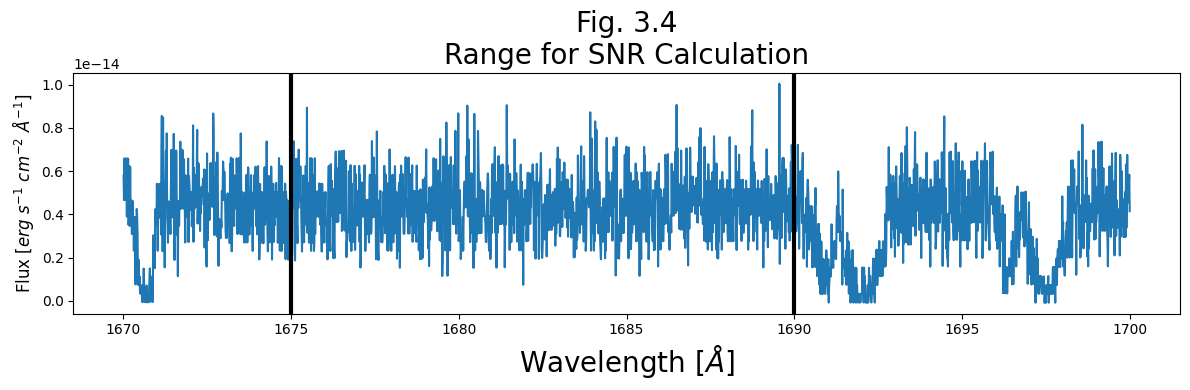

In [29]:
plt.figure(figsize=(12, 4))  # Set up figure
# Select data
wvln, flux = fuv_x1d_data["WAVELENGTH", "FLUX"][0]
# Create mask for data
wvln_range_mask = (wvln > 1670) & (wvln < 1700)

# Generate the plot itself
plt.plot(wvln[wvln_range_mask], flux[wvln_range_mask])

# Add lines showing the range we'll calculate SNR over
plt.axvline(1675,
            c='black',
            linewidth=3)
plt.axvline(1690,
            c='black',
            linewidth=3)

# Format the plot
plt.title("Fig. 3.4\nRange for SNR Calculation",
          size=20)
plt.xlabel(r'Wavelength [$\AA$]',
           size=20)
plt.ylabel(r'Flux [$erg\ s^{-1}\ cm^{-2}\ \AA^{-1}$]',
           size=12)

# Formatting figure and then saving to plots directory
plt.tight_layout()
plt.savefig(str(plotsdir/'Fig3.4.png'),
            dpi=200)

Our chosen region, between the black lines, looks quite good for calculating SNR, as it lacks obvious spectral lines.
<a id = snrcalcV></a>
### 3.3.3. Calculating the SNR
Below, we calculate the SNR of the FUV data over the region [1675, 1690]. *Note*, we input the unbinned data, and bin by an FUV Resel of 6 first. We'll leave `verbose = True`, so we can see what is going on in the function.

It turns out this dataset has a fairly low SNR. After calculating the SNR and mean SNR over the specified region, we plot both over wavelength.

First, Binning the data by  6
function `bin_by_resel` is binning by 6
In range on 0-th segment with limits: 1610.2714602559613 1810.8652338068634 
Unweighted mean SNR over the range [1675, 1690] is: 8.13060474395752
Out of range on 1-th segment with limits: 1421.9770427176002 1622.516178750544


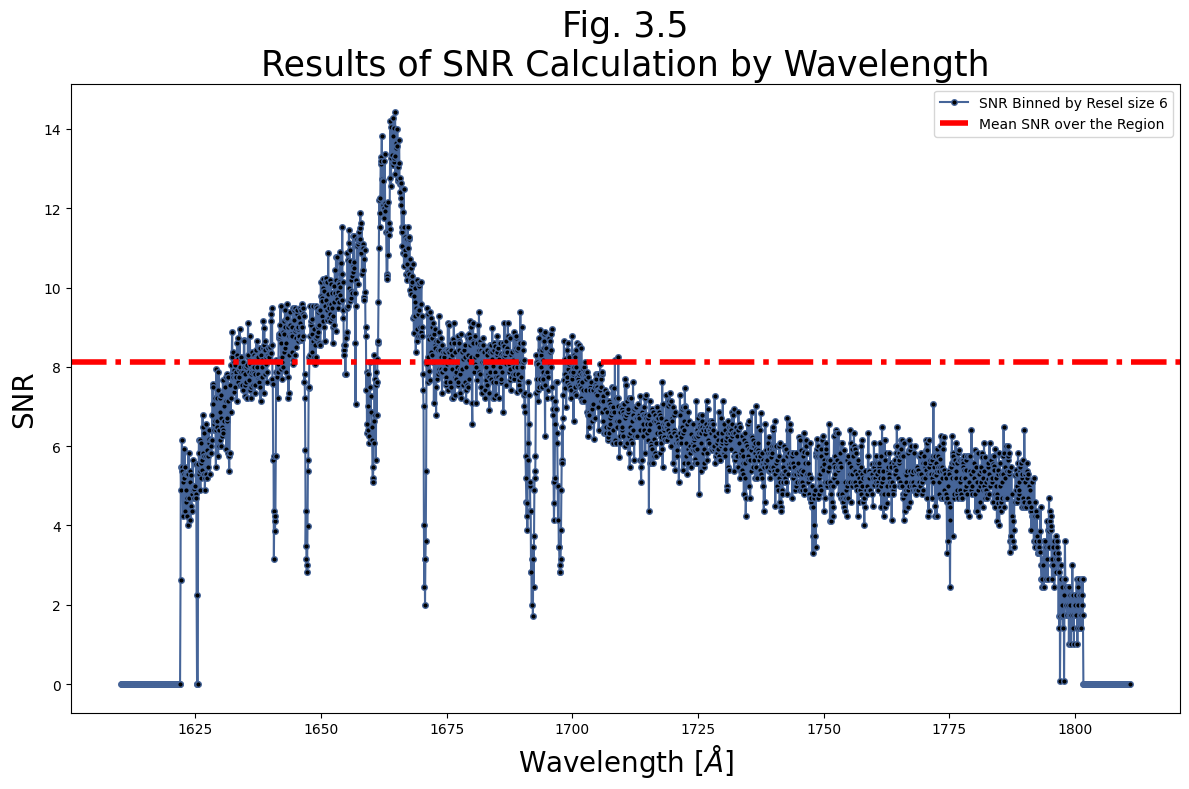

In [30]:
# Calculate the SNR
# Set the correct resel size as in the data handbook
res_size = 6

# Getting SNR over wavelengths of 1675-1690 with data binned by 6 res
meanSNR_range1675_1690, range1675_1690 = estimate_snr(
                                            fuv_x1d_data,
                                            bin_data_first=True,
                                            binsize_=res_size,
                                            snr_range=[1675, 1690])

plt.figure(figsize=(12, 8))

wvln_over_range = range1675_1690[0][0]
snr_over_range = range1675_1690[0][1]

# range1675_1690 contains a list of data for each
# segment of the detector. If the wavelength range
# for calculating S/N is in FUVA, you would
# access the WAVELENGTH and S/N as:
#     range1675_1690[1][0], range1675_1690[1][1]

# Plotting the SNR by wavelength in range 1675 - 1690 angstroms
plt.plot(wvln_over_range, snr_over_range,
         c='#466599',
         marker='.',
         markersize=8,
         markerfacecolor='black',
         label=f"SNR Binned by Resel size {res_size}")

plt.axhline(meanSNR_range1675_1690,
            c='red',
            linestyle='-.',
            linewidth=4,
            # Plot a horizontal line at y = mean SNR
            label="Mean SNR over the Region")

plt.legend(fontsize=10)

plt.title("Fig. 3.5\nResults of SNR Calculation by Wavelength",
          size=25)
plt.xlabel(r'Wavelength [$\AA$]',
           size=20)
plt.ylabel('SNR',
           size=20)

plt.tight_layout()

plt.savefig(str(plotsdir/'Fig3.5.png'),
            dpi=200)

### Exercise 3.2. *Binning the NUV Data and Calculating its SNR*

1. Bin the NUV data, remembering that the resel size is different than that for the FUV
2. Find a continuum region of the NUV data with no significant spectral lines
3. Calculate the mean SNR over that region

In [31]:
# Your code here

## Congratulations! You finished this Notebook!
### There are more COS data walkthrough Notebooks on different topics. You can find them [here](https://github.com/spacetelescope/hst_notebooks/tree/main/notebooks/COS).


---
## About this Notebook
**Author:** [Nat Kerman](nkerman@stsci.edu)

**Updated On:** 2023-03-28


> *This tutorial was generated to be in compliance with the [STScI style guides](https://github.com/spacetelescope/style-guides) and would like to cite the [Jupyter guide](https://github.com/spacetelescope/style-guides/blob/master/templates/example_notebook.ipynb) in particular.*
## Citations

If you use `astropy`, `matplotlib`, `astroquery`, or `numpy` for published research, please cite the
authors. Follow these links for more information about citations:

* [Citing `astropy`](https://docs.astropy.org/en/stable/index.html)
* [Citing `numpy`](https://numpy.org/citing-numpy/)
* [Citing `matplotlib`](https://matplotlib.org/)
* [Citing `astroquery`](https://astroquery.readthedocs.io/en/latest/)

---

[Top of Page](#topV)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/> 



## Exercise Solutions:

In [32]:
# Exercise 1.1 Solution:

# 1
# Here we read in the data - we may ignore slash warnings
nuv_x1d_data = Table.read(nuv_x1d_filepath)

# 2
nuv_x1d_header = fits.getheader(nuv_x1d_filepath)
nuv_x1d_header1 = fits.getheader(nuv_x1d_filepath, ext=1)

print(
    f"Processed at MJD = {nuv_x1d_header['PROCTIME']}"
    f"\nTaken with {nuv_x1d_header1['NUMFLASH']}"
    " wavecal flashes\n")

# 3
nuv_asn_data = Table.read(nuv_asn_filepath)
print(nuv_asn_data)

Processed at MJD = 60592.68001157
Taken with 1 wavecal flashes

   MEMNAME        MEMTYPE     MEMPRSNT
-------------- -------------- --------
     LBBD01HPQ         EXP-FP        1
     LBBD01020        PROD-FP        1


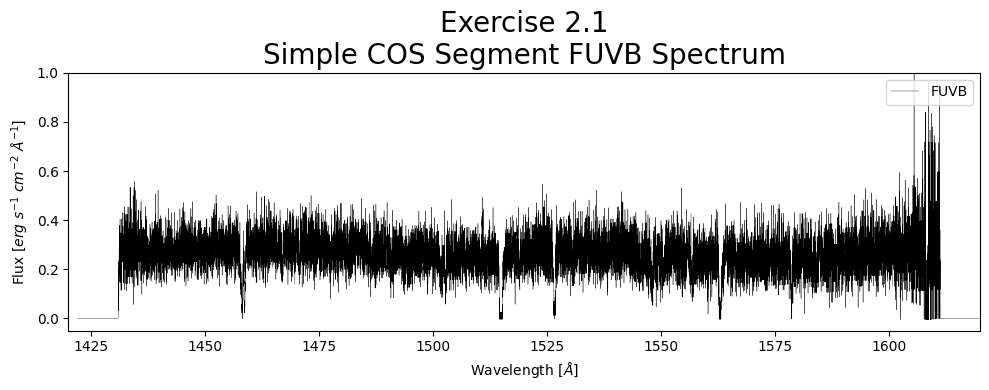

In [33]:
# Exercise 2.1 Solution:

# [0] Accesses FUVA, the longer wvln segment.
# Gets data needed to plot a spectrum
wvln = fuv_x1d_data["WAVELENGTH"][1]
flux = fuv_x1d_data["FLUX"][1]
segment = fuv_x1d_data["SEGMENT"][1]

# [1] Accesses FUVB
# Adds unit to the wvln of Angstroms
wvln *= u.AA
# Adds unit to the flux of erg / (Angstrom cm2 s)
flux *= u.erg/(u.second * u.AA * (u.cm)**2)
flux /= (np.nanmax(flux))
# Allows us to view the units attached to the data as the axes labels.
# This isn't generally necessary unless you want the unit support.
with quantity_support():
    fig1, ax = plt.subplots(1, 1, figsize=(10, 4),
                            dpi=100)

    # The next few lines are where we place data onto the plot:
    ###############
    ax.plot(wvln, flux,
            linestyle="-",
            linewidth=0.25,
            c='black',
            marker='',
            label=segment)

    ax.set_title("Exercise 2.1\nSimple COS Segment FUVB Spectrum",
                 size=20)

    # Setting the x-axis label
    ax.set_xlabel(r'Wavelength [$\AA$]')
    # Setting the y-axis label
    ax.set_ylabel(r'Flux [$erg\ s^{-1}\ cm^{-2}\ \AA^{-1}$]')

    plt.xlim(1420, 1620)
    plt.ylim(-0.05, 1)

    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()

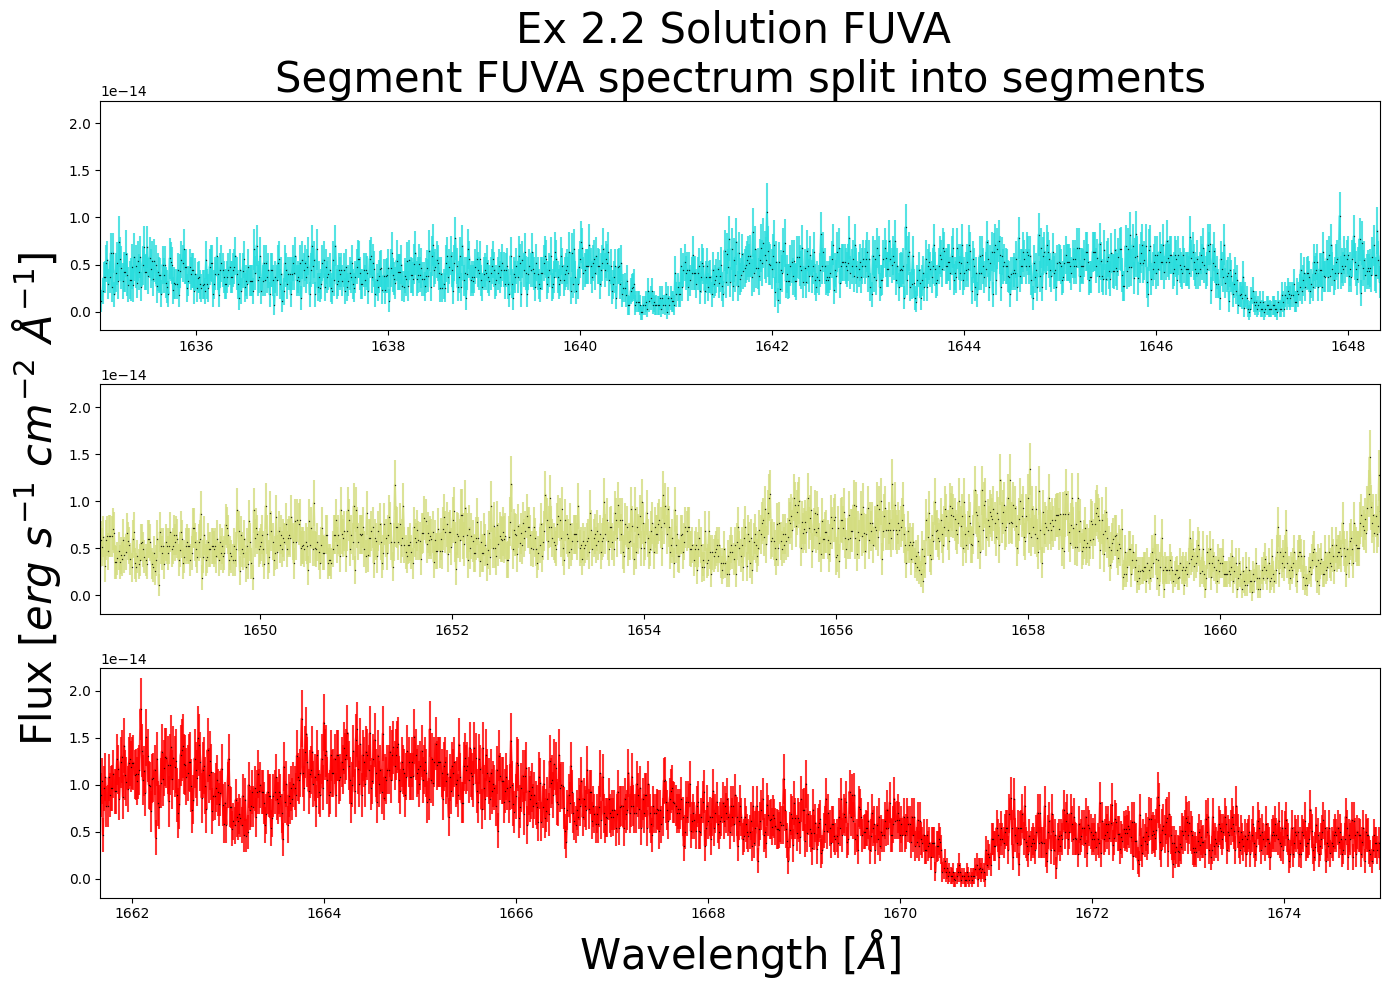

In [34]:
# Exercise 2.2 Solution

# Selects all useful data for the chosen segment = FUVA
wvln, flux = fuv_x1d_data['WAVELENGTH', 'FLUX'][0]
fluxErr, segment = fuv_x1d_data['ERROR', 'SEGMENT'][0]

minx, maxx = 1635, 1675
miny, maxy = min(flux), max(flux)

wvln_range_mask = (wvln > minx) & (wvln < maxx)

wvln = wvln[wvln_range_mask]
flux = flux[wvln_range_mask]
fluxErr = fluxErr[wvln_range_mask]

rangex = maxx - minx
fig = plt.figure(figsize=(14, 10))

nRows = 3

for i in range(nRows):
    min_ = minx + i*rangex/nRows
    max_ = minx + (i+1)*rangex/nRows
    ax = plt.subplot(nRows, 1, i+1)

    # A way to set title, xlabel, and ylabel independent of # of rows
    if i == 0:
        ax.set_title(
            f"Ex 2.2 Solution FUV{segment[-1]} "
            f"\nSegment {segment} "
            "spectrum split into segments",
            size=30)

    if i == nRows - 1:
        ax.set_xlabel(r'Wavelength [$\AA$]',
                      size=30)

    if i == int(nRows/2):
        ax.set_ylabel(r'Flux [$erg\ s^{-1}\ cm^{-2}\ \AA ^{-1}$]',
                      size=30)

    ax.errorbar(wvln, flux, fluxErr,
                c=plt.cm.rainbow((i+1)/nRows),
                alpha=0.8,
                marker='.',
                markerfacecolor='k',
                markersize=2,
                mew=0)

    ax.set_xlim(min_, max_)

plt.tight_layout()

plt.show()

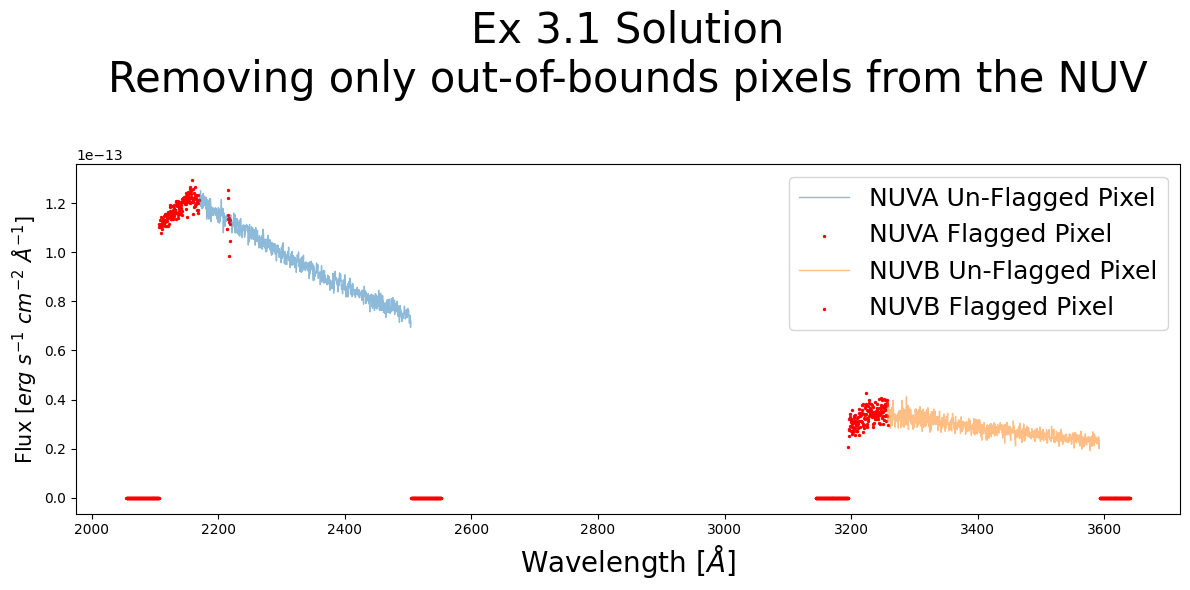

In [35]:
# Exercise 3.1 Solution

plt.figure(figsize=(12, 6))
for i in range(2):
    dataQual = nuv_x1d_data["DQ"][i]
    wvln = nuv_x1d_data["WAVELENGTH"][i]
    flux = nuv_x1d_data["FLUX"][i]
    fluxErr = nuv_x1d_data["ERROR"][i]
    segment = nuv_x1d_data["SEGMENT"][i]

    plt.plot(wvln[dataQual == 0], flux[dataQual == 0],
             linewidth=1,
             alpha=0.5,
             label=f"{segment} Un-Flagged Pixel")

    plt.scatter(wvln[dataQual != 0], flux[dataQual != 0],
                s=2,
                c='r',
                alpha=1,
                label=f"{segment} Flagged Pixel")

plt.legend(fontsize=18)

plt.title(
    "Ex 3.1 Solution\nRemoving only out-of-bounds "
    "pixels from the NUV\n",
    size=30)
plt.xlabel(r'Wavelength [$\AA$]',
           size=20)
plt.ylabel(r'Flux [$erg\ s^{-1}\ cm^{-2}\ \AA^{-1}$]',
           size=15)

plt.tight_layout()

First, Binning the data by  3
function `bin_by_resel` is binning by 3
Out of range on 0-th segment with limits: 2055.2227946721123 2551.202543205818
In range on 1-th segment with limits: 3144.4680068817165 3639.1168209501548 
Unweighted mean SNR over the range [3400, 3450] is: 29.33061408996582
Out of range on 2-th segment with limits: 2141.381207452109 2387.0087020695464


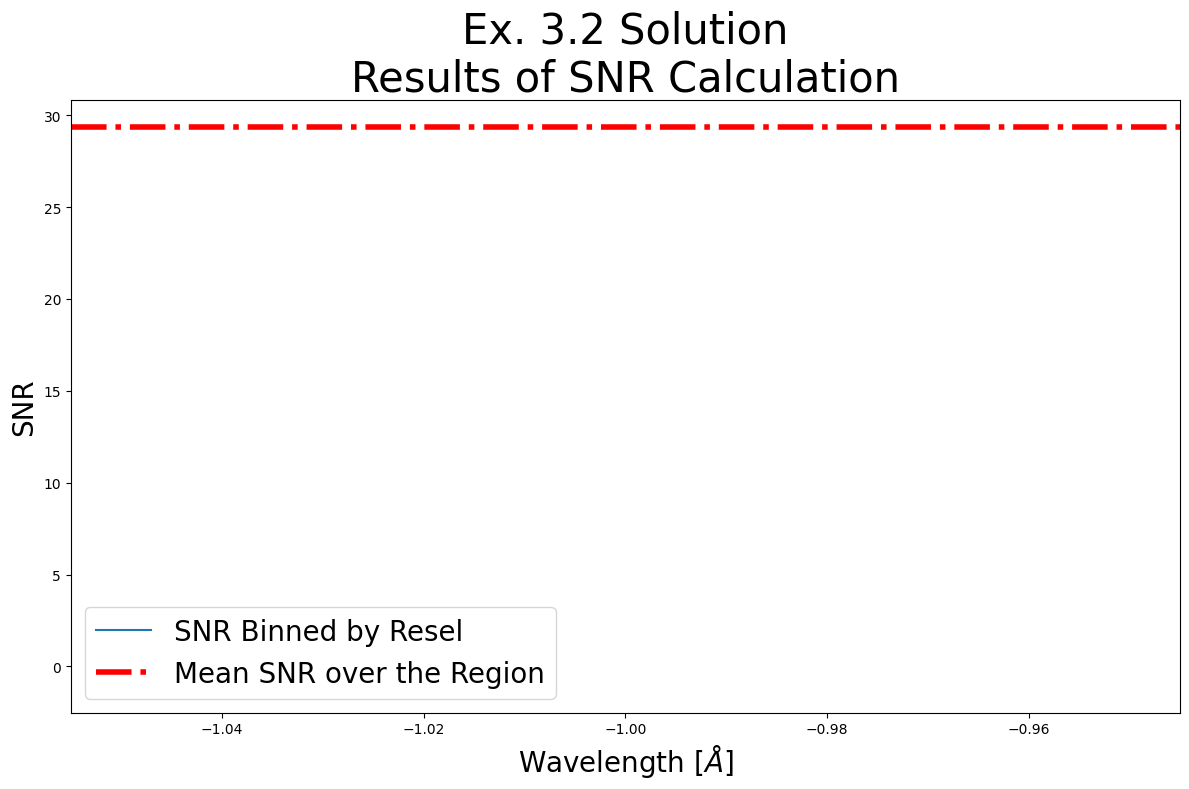

In [36]:
# Exercise 3.2 Solution

# This whole process can be accomplished in one line, provided we
# use Fig 2.6 to find a line free region. We use the estimate_snr
# function to bin by NUV resel size of 3, then mean calculate
# SNR over the region.

meanSNR_nuv_range, nuv_range = estimate_snr(
                                    nuv_x1d_data,
                                    bin_data_first=True,
                                    binsize_=3,
                                    snr_range=[3400, 3450])

# Let's plot it as in Fig 3.5:

plt.figure(figsize=(12, 8))

plt.plot(nuv_range[1][0], nuv_range[1][1],
         label="SNR Binned by Resel")

plt.axhline(meanSNR_nuv_range,
            c='r',
            linestyle='-.',
            linewidth=4,
            label="Mean SNR over the Region")

plt.legend(fontsize=20)

plt.title("Ex. 3.2 Solution\nResults of SNR Calculation",
          size=30)
plt.xlabel(r'Wavelength [$\AA$]',
           size=20)
plt.ylabel('SNR',
           size=20)

plt.tight_layout()